# Time Series Analysis

## Import packages

In [1]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import statsmodels

In [2]:
# matplotlib configuration

plt.rcParams["font.family"] = "serif"
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["figure.dpi"] = 150
plt.rcParams['figure.figsize'] = 20, 10

def newfigure(*args, **kwargs):
    fig, ax = plt.subplots(*args, **kwargs)
    for i, a in enumerate(fig.axes):
        a.tick_params(direction='in', grid_linestyle=":", top=True, right=True)
        a.grid(which='major', axis='both', linestyle=":")
    return fig, ax

## Import the data

All the fields are populated. No missing fields to clear up. There may not be consistent time deltas for script calls that did not get logged properly. This should not effect the analysis too much.

In [3]:
file_data = []
print(os.listdir())

weather = pd.read_csv(
    "weather.csv",
    index_col="SCRIPT_TIME",
    parse_dates=["SCRIPT_TIME", "DS_TIME"])

stocks = pd.read_csv(
    "stocks.csv",
    index_col="SCRIPT_TIME",
    parse_dates=["SCRIPT_TIME", "AV_CURRENCY_REFRESH"])

weather = weather[~weather.index.duplicated()]
stocks = stocks[~stocks.index.duplicated()]

['stocks.py', '.DS_Store', 'requirements.txt', 'weather.py', '__pycache__', 'test.py', 'Time Series Analysis.ipynb', 'google_credentials.json', 'utils.py', 'weather.csv', 'credentials.json', '.ipynb_checkpoints', 'ansi.py', 'Data_Analysis.ipynb', 'gsheet.py', 'database_merge.py', 'stocks.csv']


In [4]:
weather.head()

DS_TIME  DS_TEMP  DS_PRECIP  DS_PRECIP_INT  \
SCRIPT_TIME                                                                  
2018-12-23 21:15:03 2018-12-23 21:15:04     3.71       1.00         1.4935   
2018-12-23 21:18:04 2018-12-23 21:18:04     3.70       1.00         1.3132   
2018-12-23 21:21:04 2018-12-23 21:21:04     3.70       0.99         0.7112   
2018-12-23 21:24:03 2018-12-23 21:24:04     3.69       0.90         0.6325   
2018-12-23 21:27:04 2018-12-23 21:27:05     3.69       1.00         0.3099   

                     DS_HUM  DS_PRESSURE  DS_STORM_DIST  
SCRIPT_TIME                                              
2018-12-23 21:15:03    0.91      1020.48              0  
2018-12-23 21:18:04    0.91      1020.53              0  
2018-12-23 21:21:04    0.91      1020.59              0  
2018-12-23 21:24:03    0.91      1020.65              0  
2018-12-23 21:27:04    0.91      1020.71              0

In [5]:
stocks.head()

AV_FTSE_PRICE AV_CURRENCY_REFRESH  AV_GBP_USD
SCRIPT_TIME                                                       
2018-12-23 20:36:51        6721.17 2018-12-23 20:36:52    1.263344
2018-12-23 20:37:04        6721.17 2018-12-23 20:37:05    1.263344
2018-12-23 20:42:09        6721.17 2018-12-23 20:42:11    1.263408
2018-12-23 20:45:04        6721.17 2018-12-23 20:45:05    1.263392
2018-12-23 20:48:03        6721.17 2018-12-23 20:48:05    1.263583

## Simple Visuals

Some simple plots of the data to see how it looks.

### Weather

From investigation it seems that the more useful data will be either temperature, humidity, or pressure. These all have interesting signals, however both the temperature and humidity signal are rather erratic which may be due to the hyperlocalised prediction provided by the DarkSky API. This data may need to be smoothed a little bit to assist with correlation. 

Due to the lack of rain/storms during the collection period, this data will not be used during analysis phase.

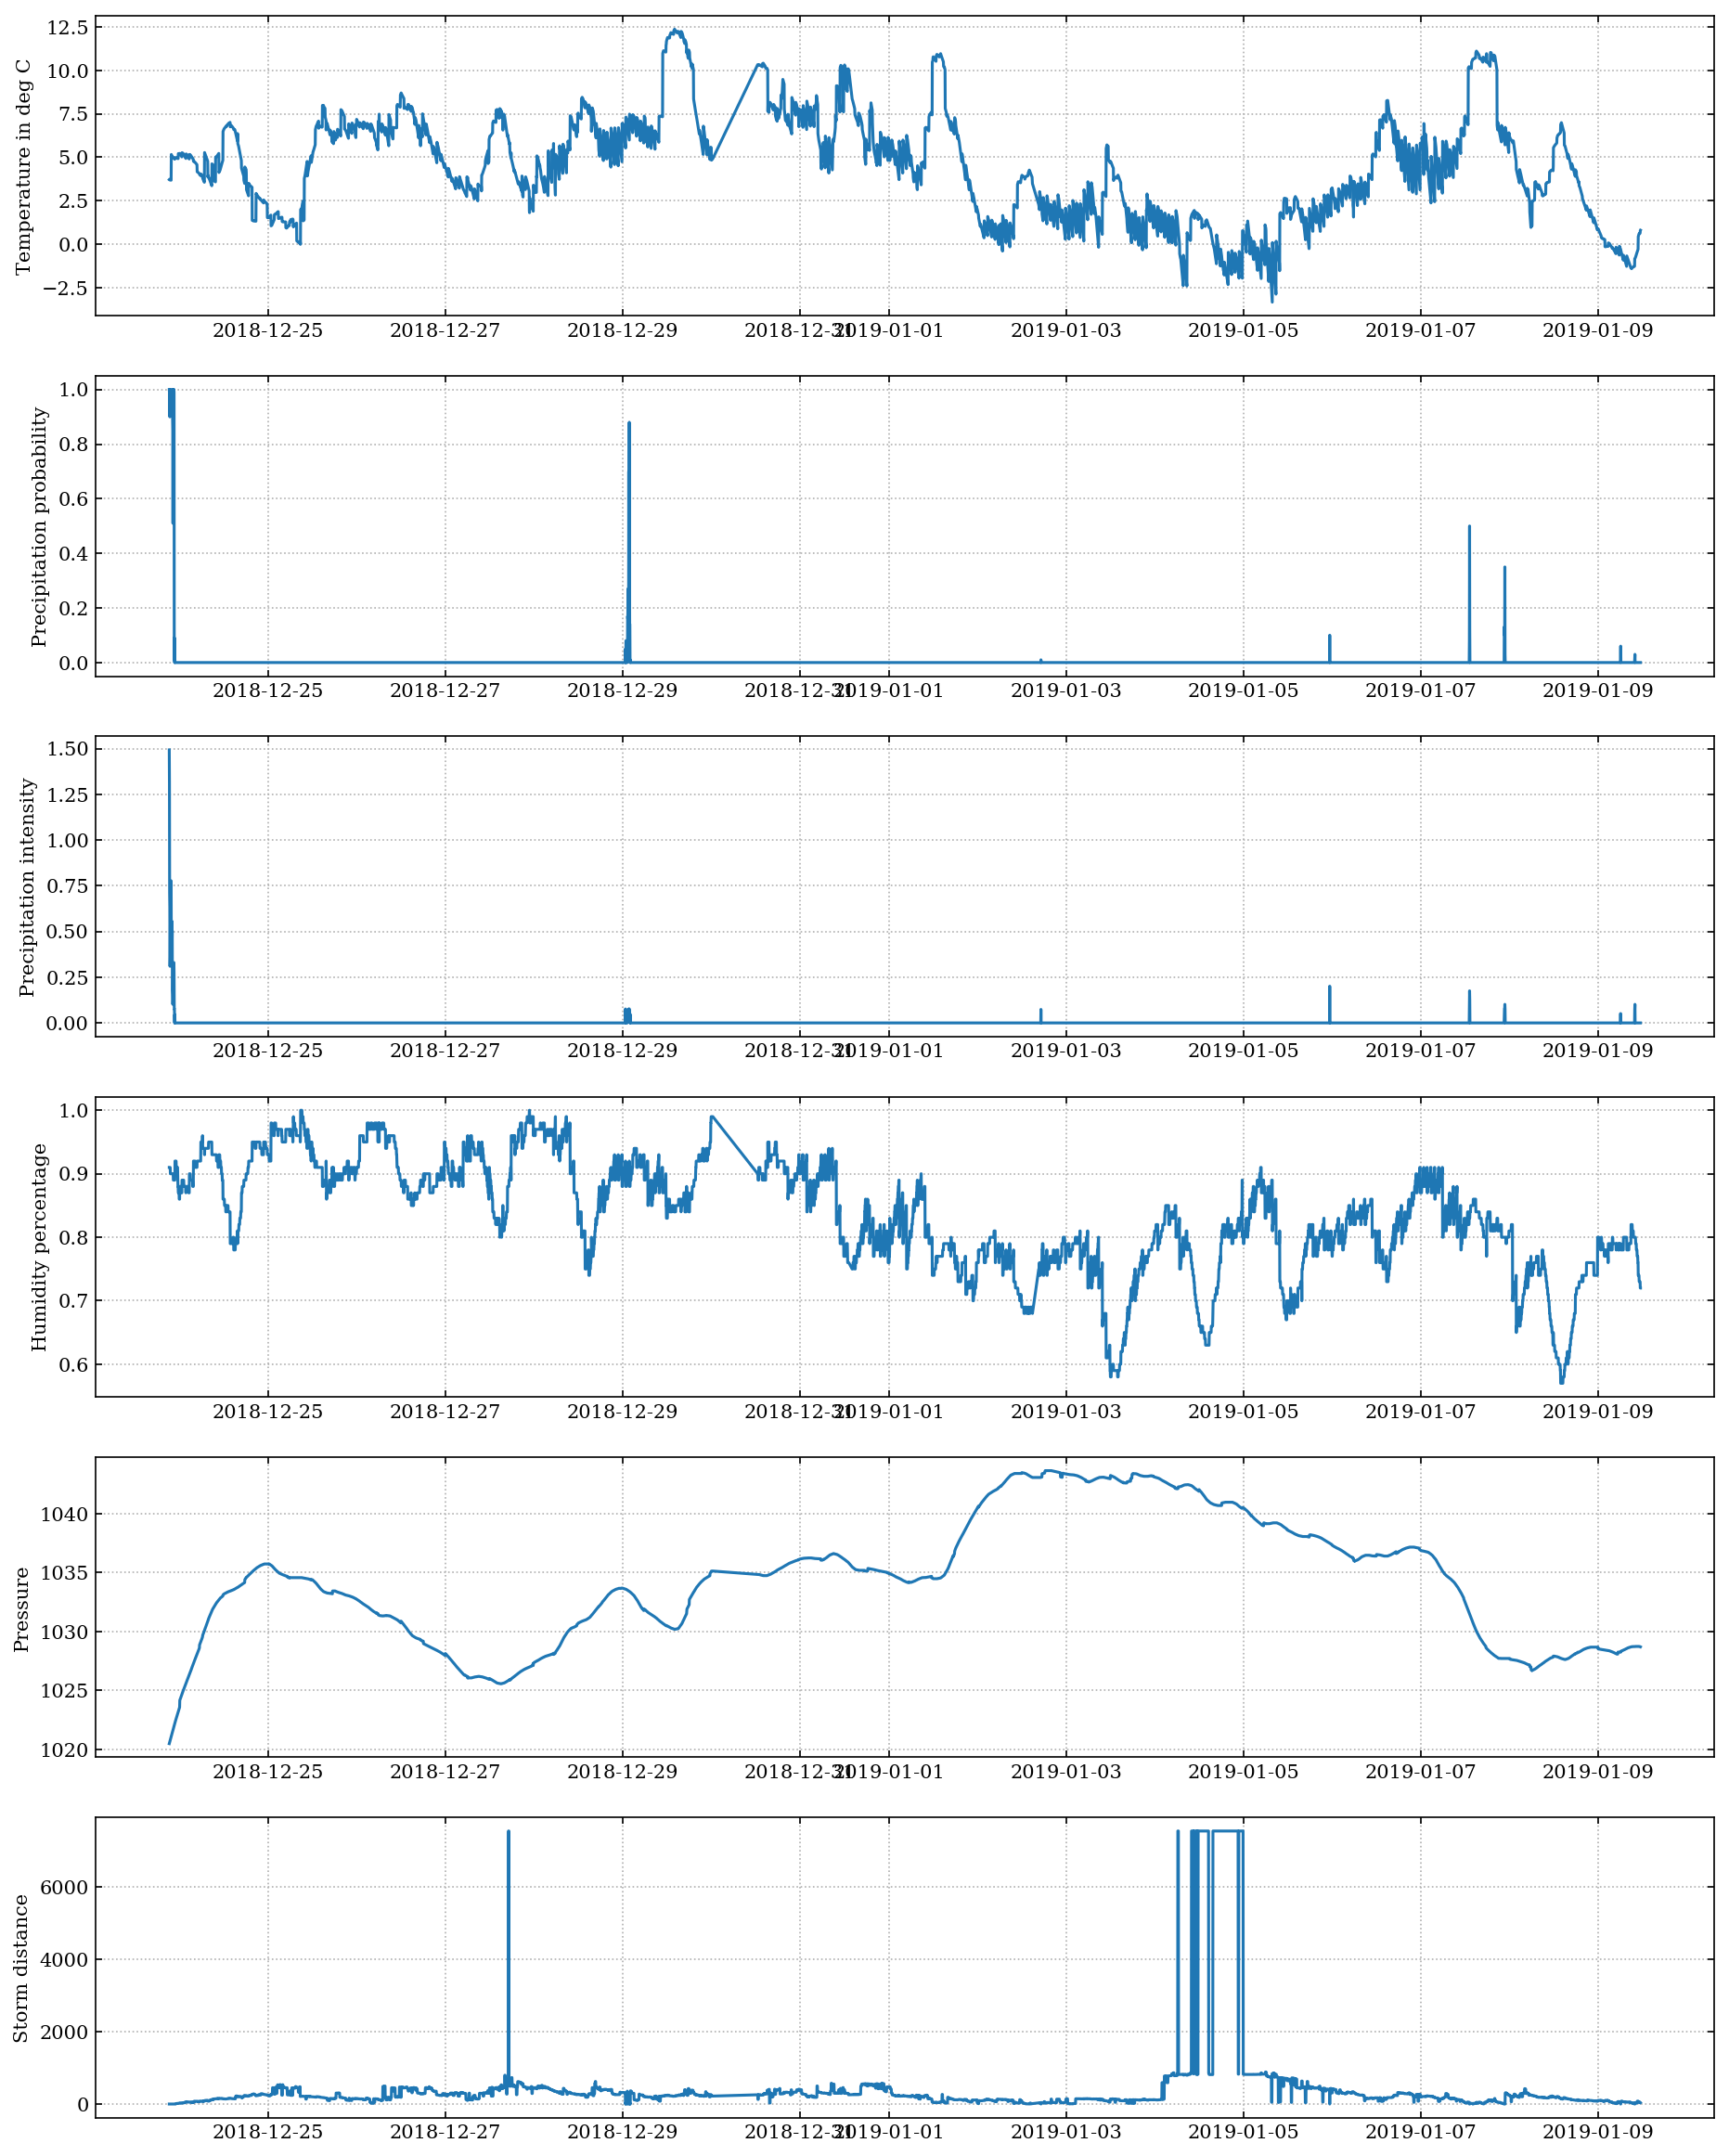

In [6]:
fig, ax = newfigure(6, figsize=(15,20))

ax[0].plot(weather['DS_TEMP'])
ax[0].set_ylabel("Temperature in deg C")

ax[1].plot(weather['DS_PRECIP'])
ax[1].set_ylabel("Precipitation probability")

ax[2].plot(weather['DS_PRECIP_INT'])
ax[2].set_ylabel("Precipitation intensity")

ax[3].plot(weather['DS_HUM'])
ax[3].set_ylabel("Humidity percentage")

ax[4].plot(weather['DS_PRESSURE'])
ax[4].set_ylabel("Pressure")

ax[5].plot(weather['DS_STORM_DIST'])
ax[5].set_ylabel("Storm distance")

plt.show()

### Stocks & Forex

The main problem with the price data is that there are many periods where the markets are closed. This is particularly pronminent with the the FTSE 100 quote.

For this reason, only the GBP/USD rate will be used for analysis with weather data.

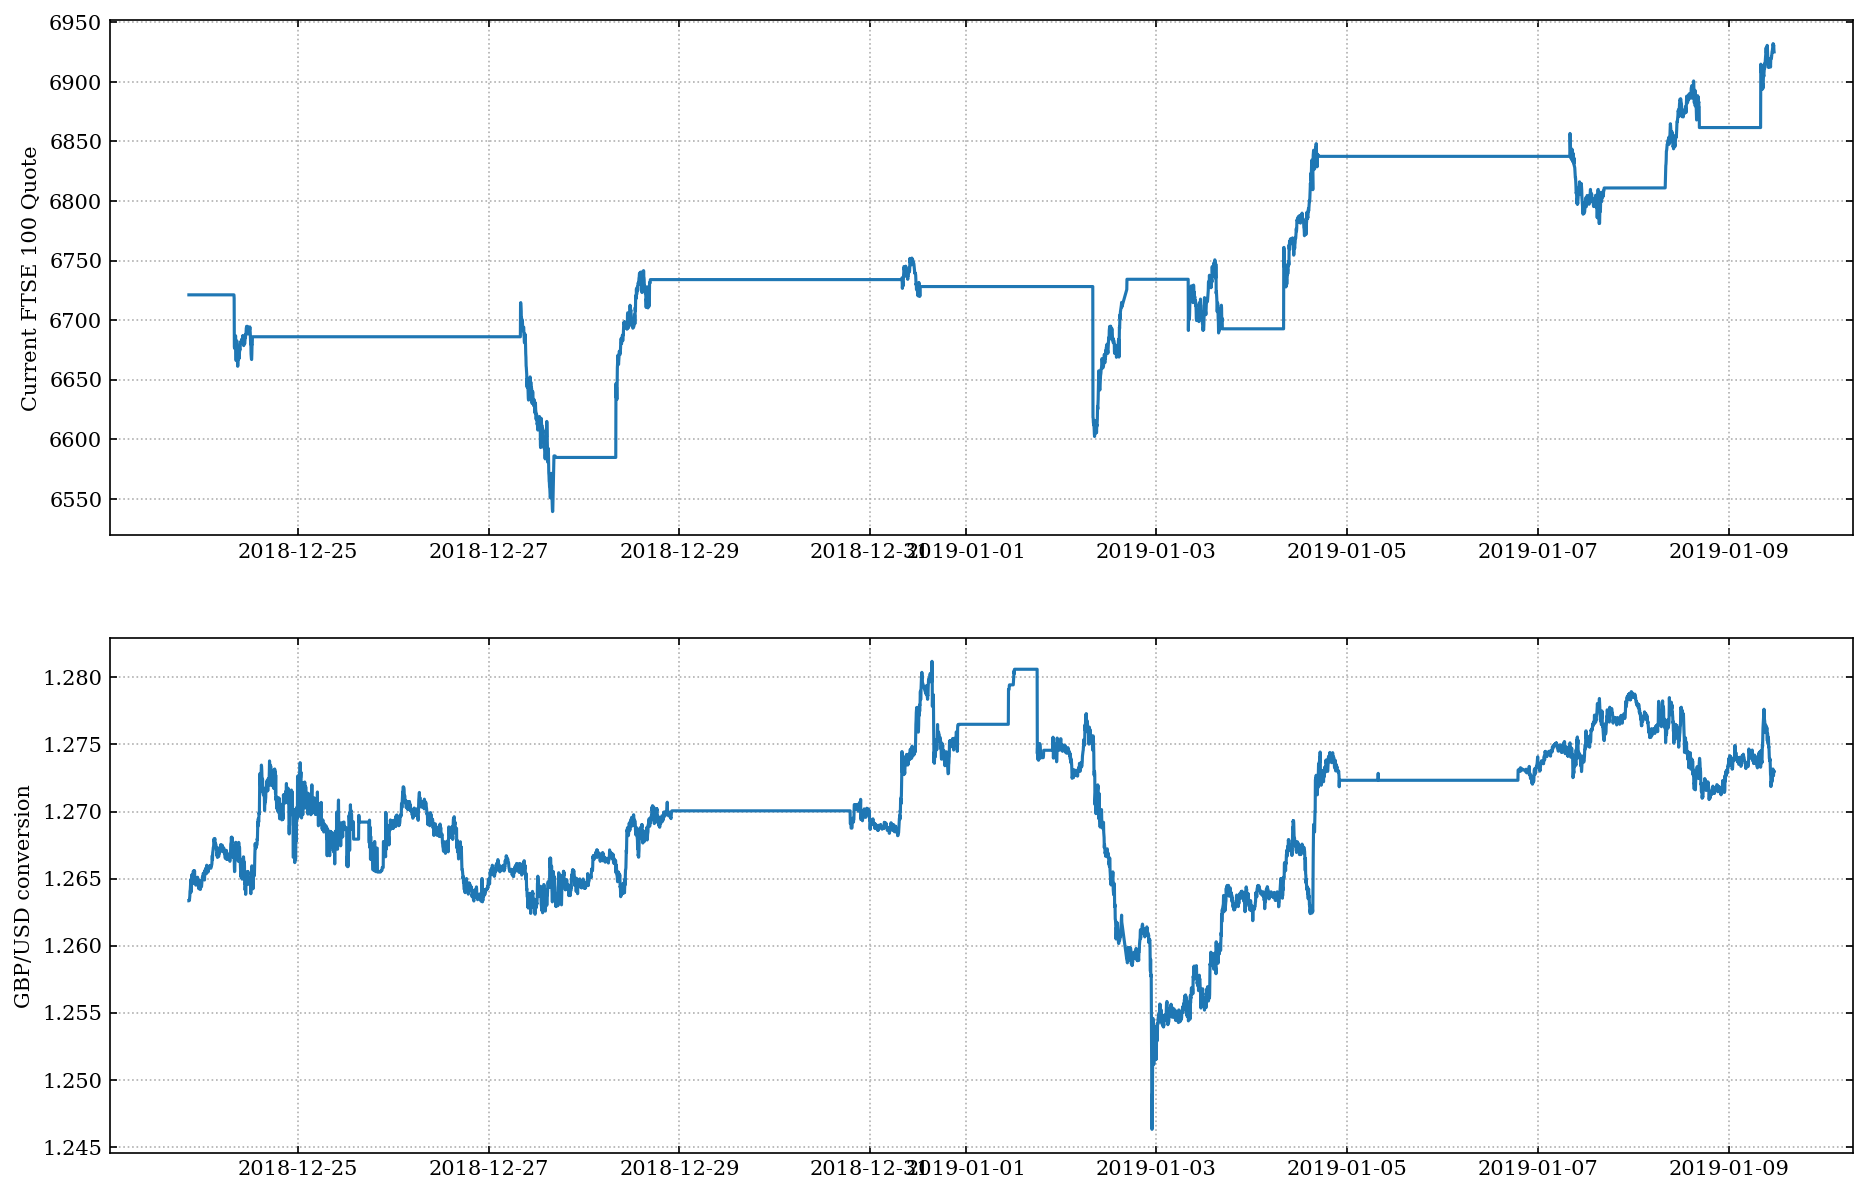

In [7]:
fig, ax = newfigure(2, figsize=(15,10))

ax[0].plot(stocks['AV_FTSE_PRICE'])
ax[0].set_ylabel("Current FTSE 100 Quote")

ax[1].plot(stocks['AV_GBP_USD'])
ax[1].set_ylabel("GBP/USD conversion")

plt.show()

### Cleaning up selected datasets and reformatting

The selected data sets (seen below) were chosen and standardised to make the analysis easier. Each was resampled from their original roughly 3 minute sample rate to every 30 minutes. This helped to reduce the uncertainty jitter in the raw data. This new sample rate is not was intended for the data when it was collected however due to the inaccuracy of the Dark Sky API it was a necessary step.

Any missing data in the sets was then interpolated linearly. This helps to fill in any gaps in the data collection process.

                     TEMPERATURE  HUMIDITY     PRESSURE     FOREX
TIME                                                             
2018-12-23 21:10:00     3.705000    0.9100  1020.505000  1.264404
2018-12-23 21:20:00     3.693333    0.9100  1020.650000  1.265102
2018-12-23 21:30:00     3.690000    0.9025  1020.850000  1.264990
2018-12-23 21:40:00     4.173333    0.9000  1021.050000  1.265529
2018-12-23 21:50:00     5.096667    0.9000  1021.226667  1.265278


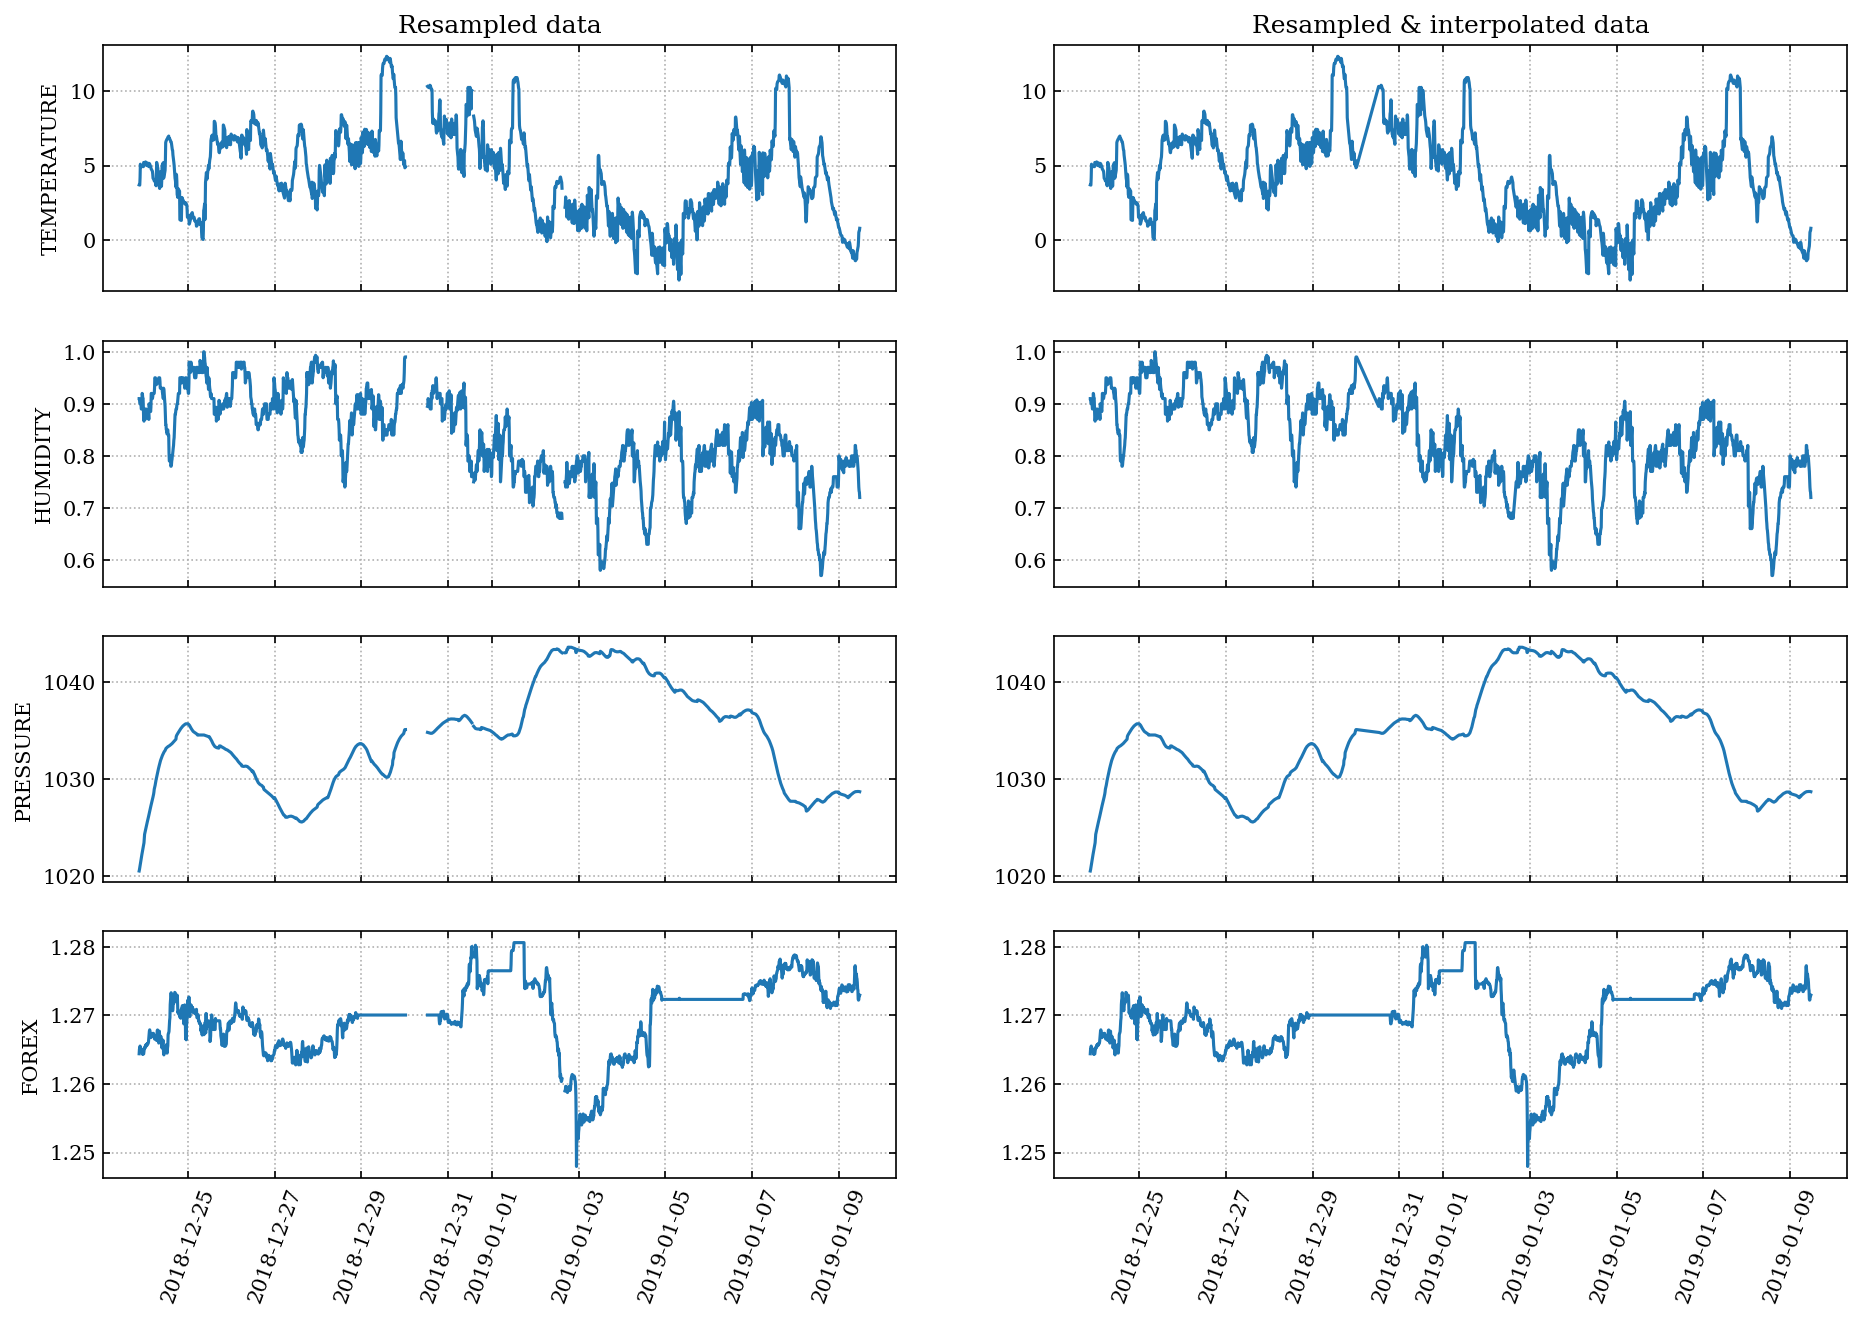

In [8]:
forex10 = stocks['AV_GBP_USD'].resample("10min").mean()

sample_rate = "10min"

# Create new Series for desired data
temp = weather['DS_TEMP'].resample(sample_rate).mean().rename("TEMPERATURE")
humi = weather['DS_HUM'].resample(sample_rate).mean().rename("HUMIDITY")
pres = weather['DS_PRESSURE'].resample(sample_rate).mean().rename("PRESSURE")
forx = stocks['AV_GBP_USD'].resample(sample_rate).mean().rename("FOREX")

# Combine Series into DataFrame
cdata = pd.concat([temp,humi,pres,forx], axis=1)
# Rename index column
cdata.rename_axis('TIME', inplace=True)
# Delete first row to ensure no NaN
cdata = cdata.iloc[4:]
print(cdata.head())

fig, axs = newfigure(len(cdata.columns.values), 2, figsize=(15,10), sharex=True)

for i, name in enumerate(cdata.columns.values):
    axs[i,0].xaxis.set_tick_params(rotation=70)
    axs[i,0].plot(cdata[name])
    axs[i,0].set_ylabel(name)
    cdata[name] = cdata[name].interpolate('linear')
    
    axs[i,1].xaxis.set_tick_params(rotation=70)
    axs[i,1].plot(cdata[name])

axs[0,0].set_title('Resampled data')
axs[0,1].set_title('Resampled & interpolated data')
plt.show()

## Decomposition

The datasets are decomposed into their observed, trend, seasonal, and residual data.

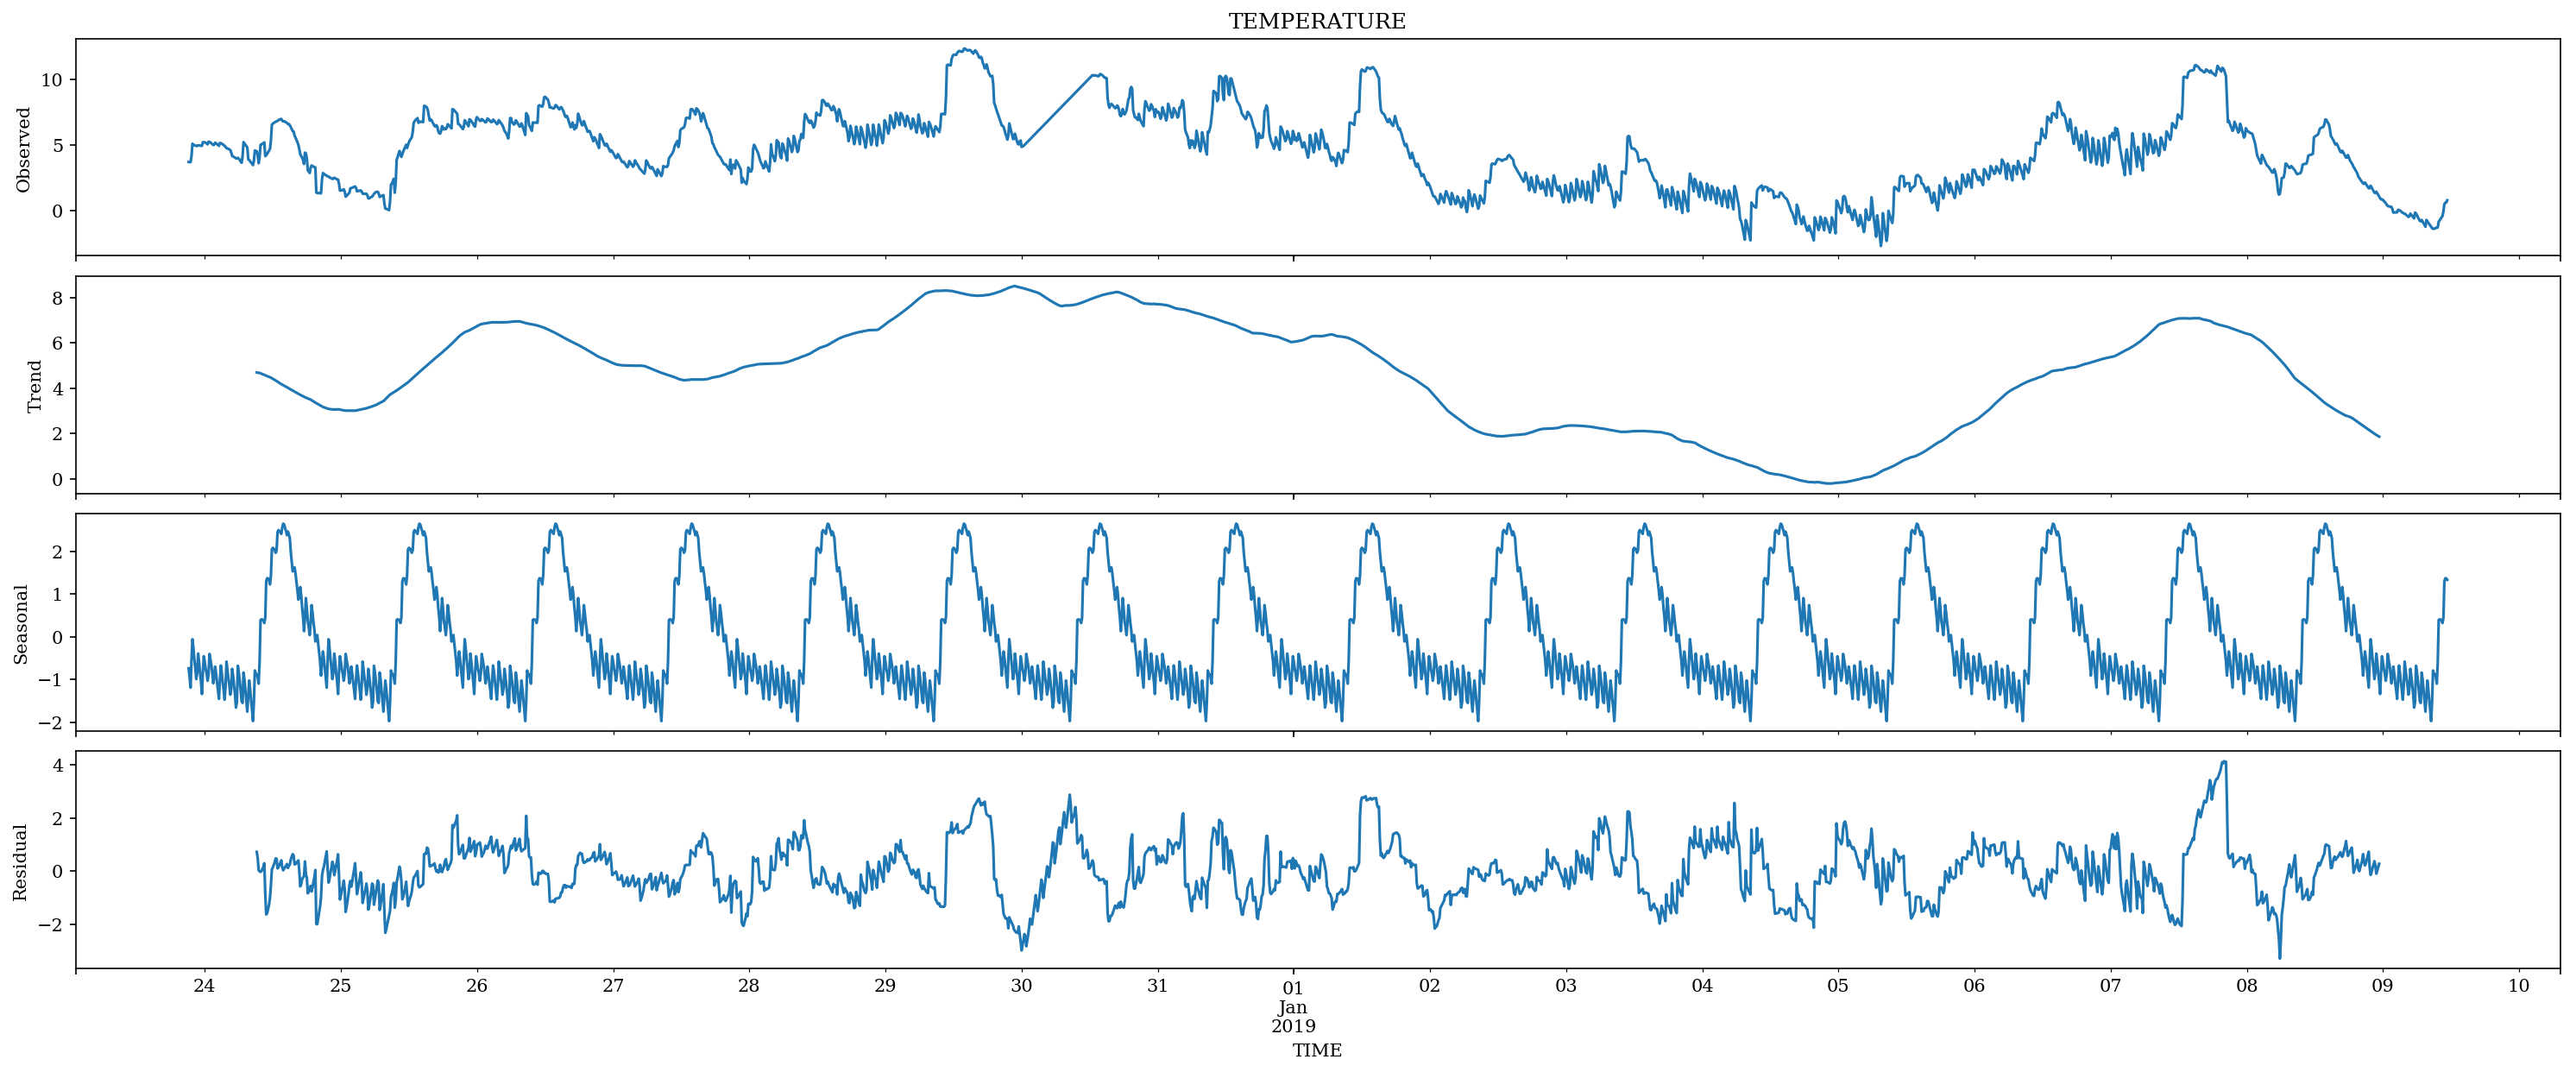

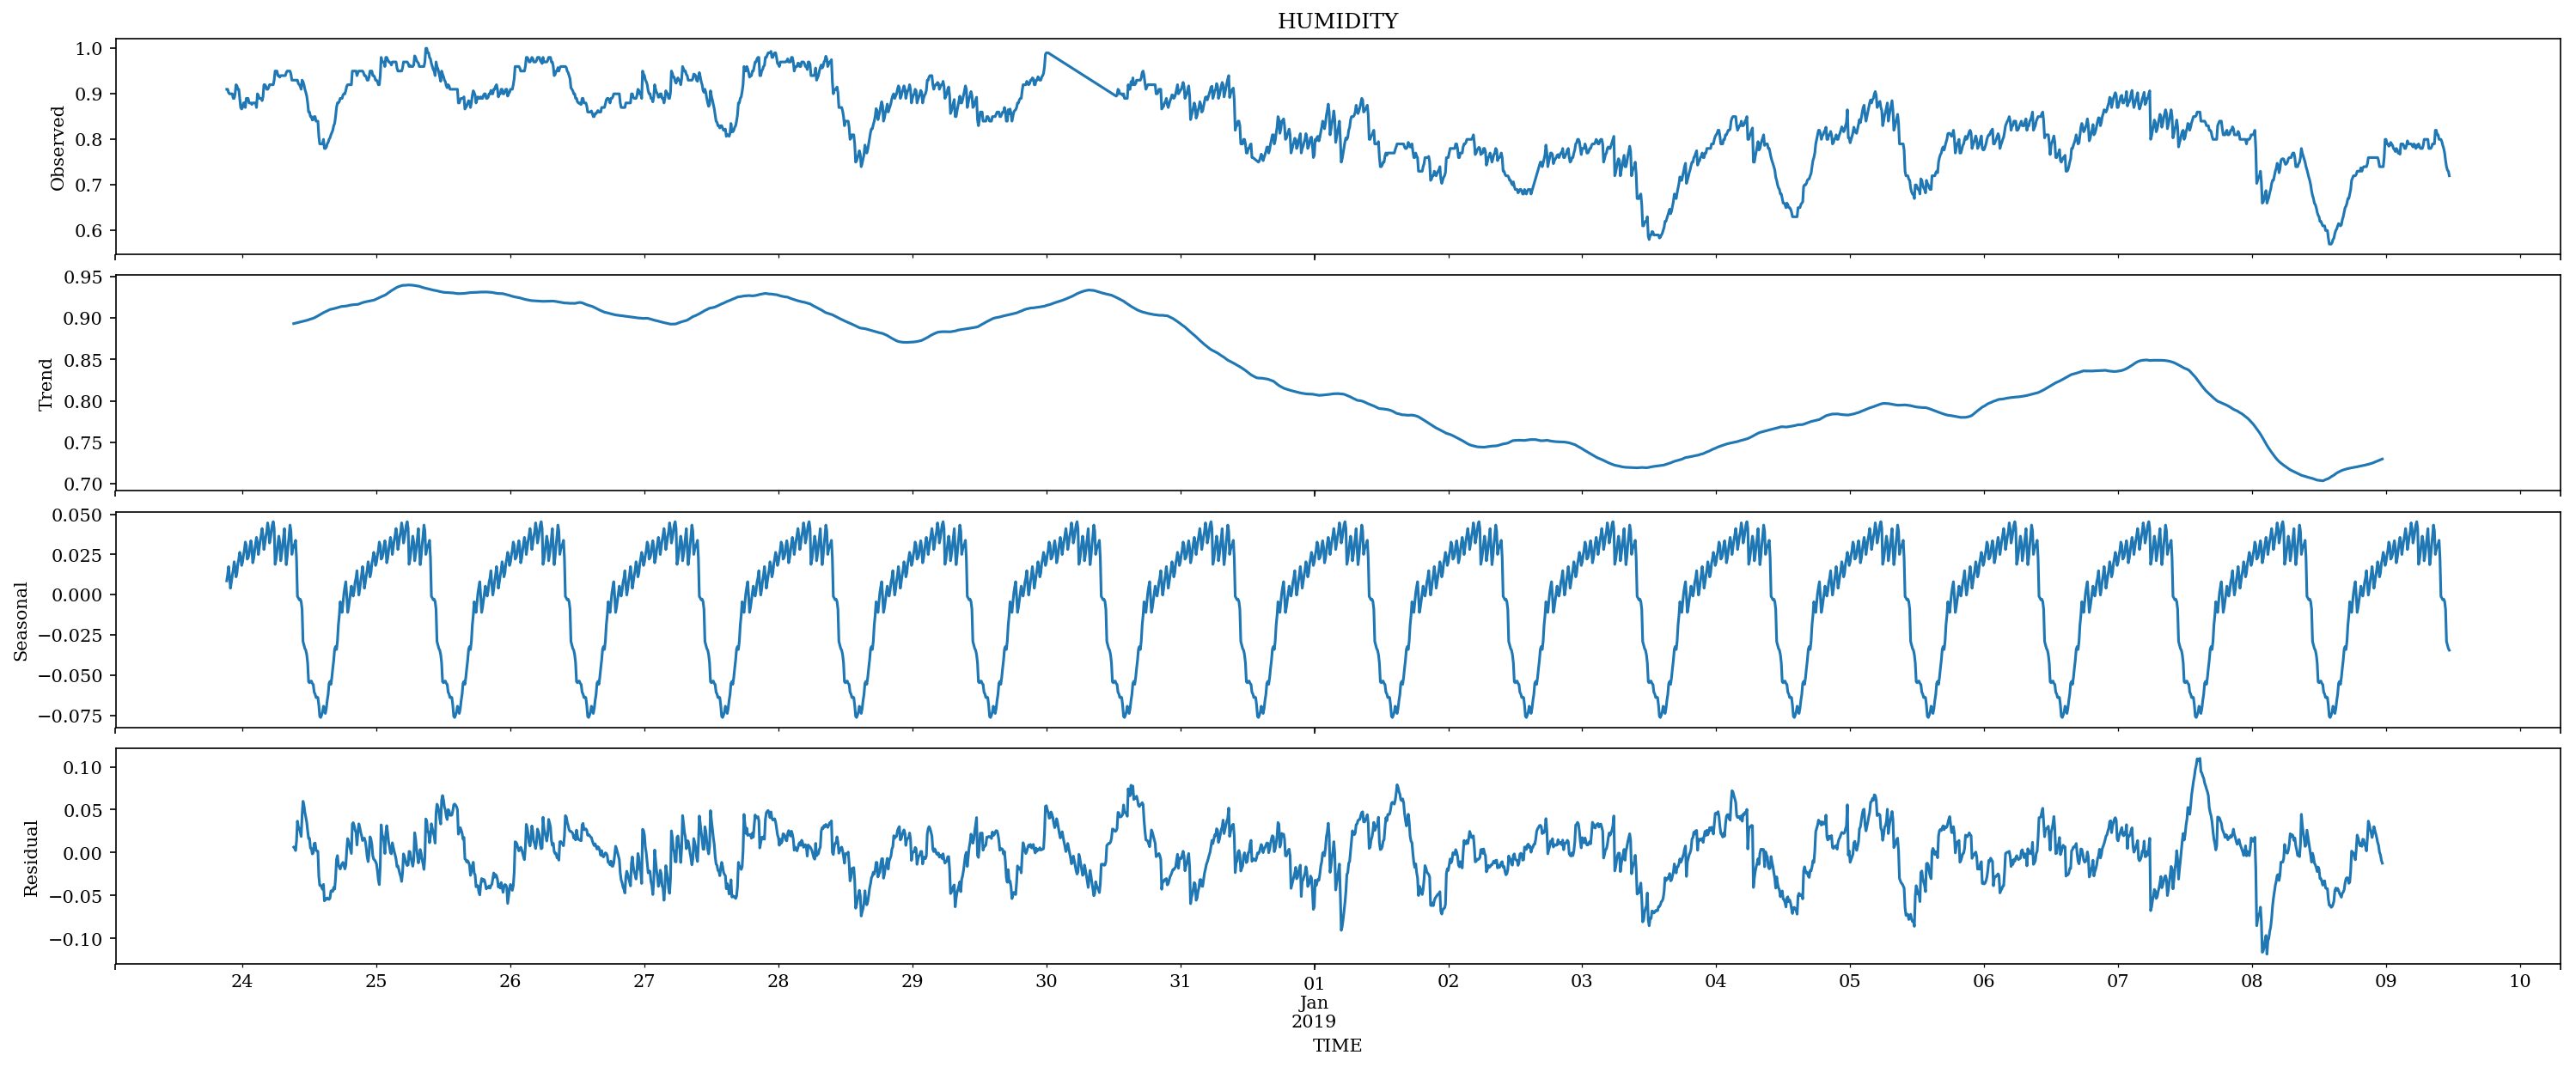

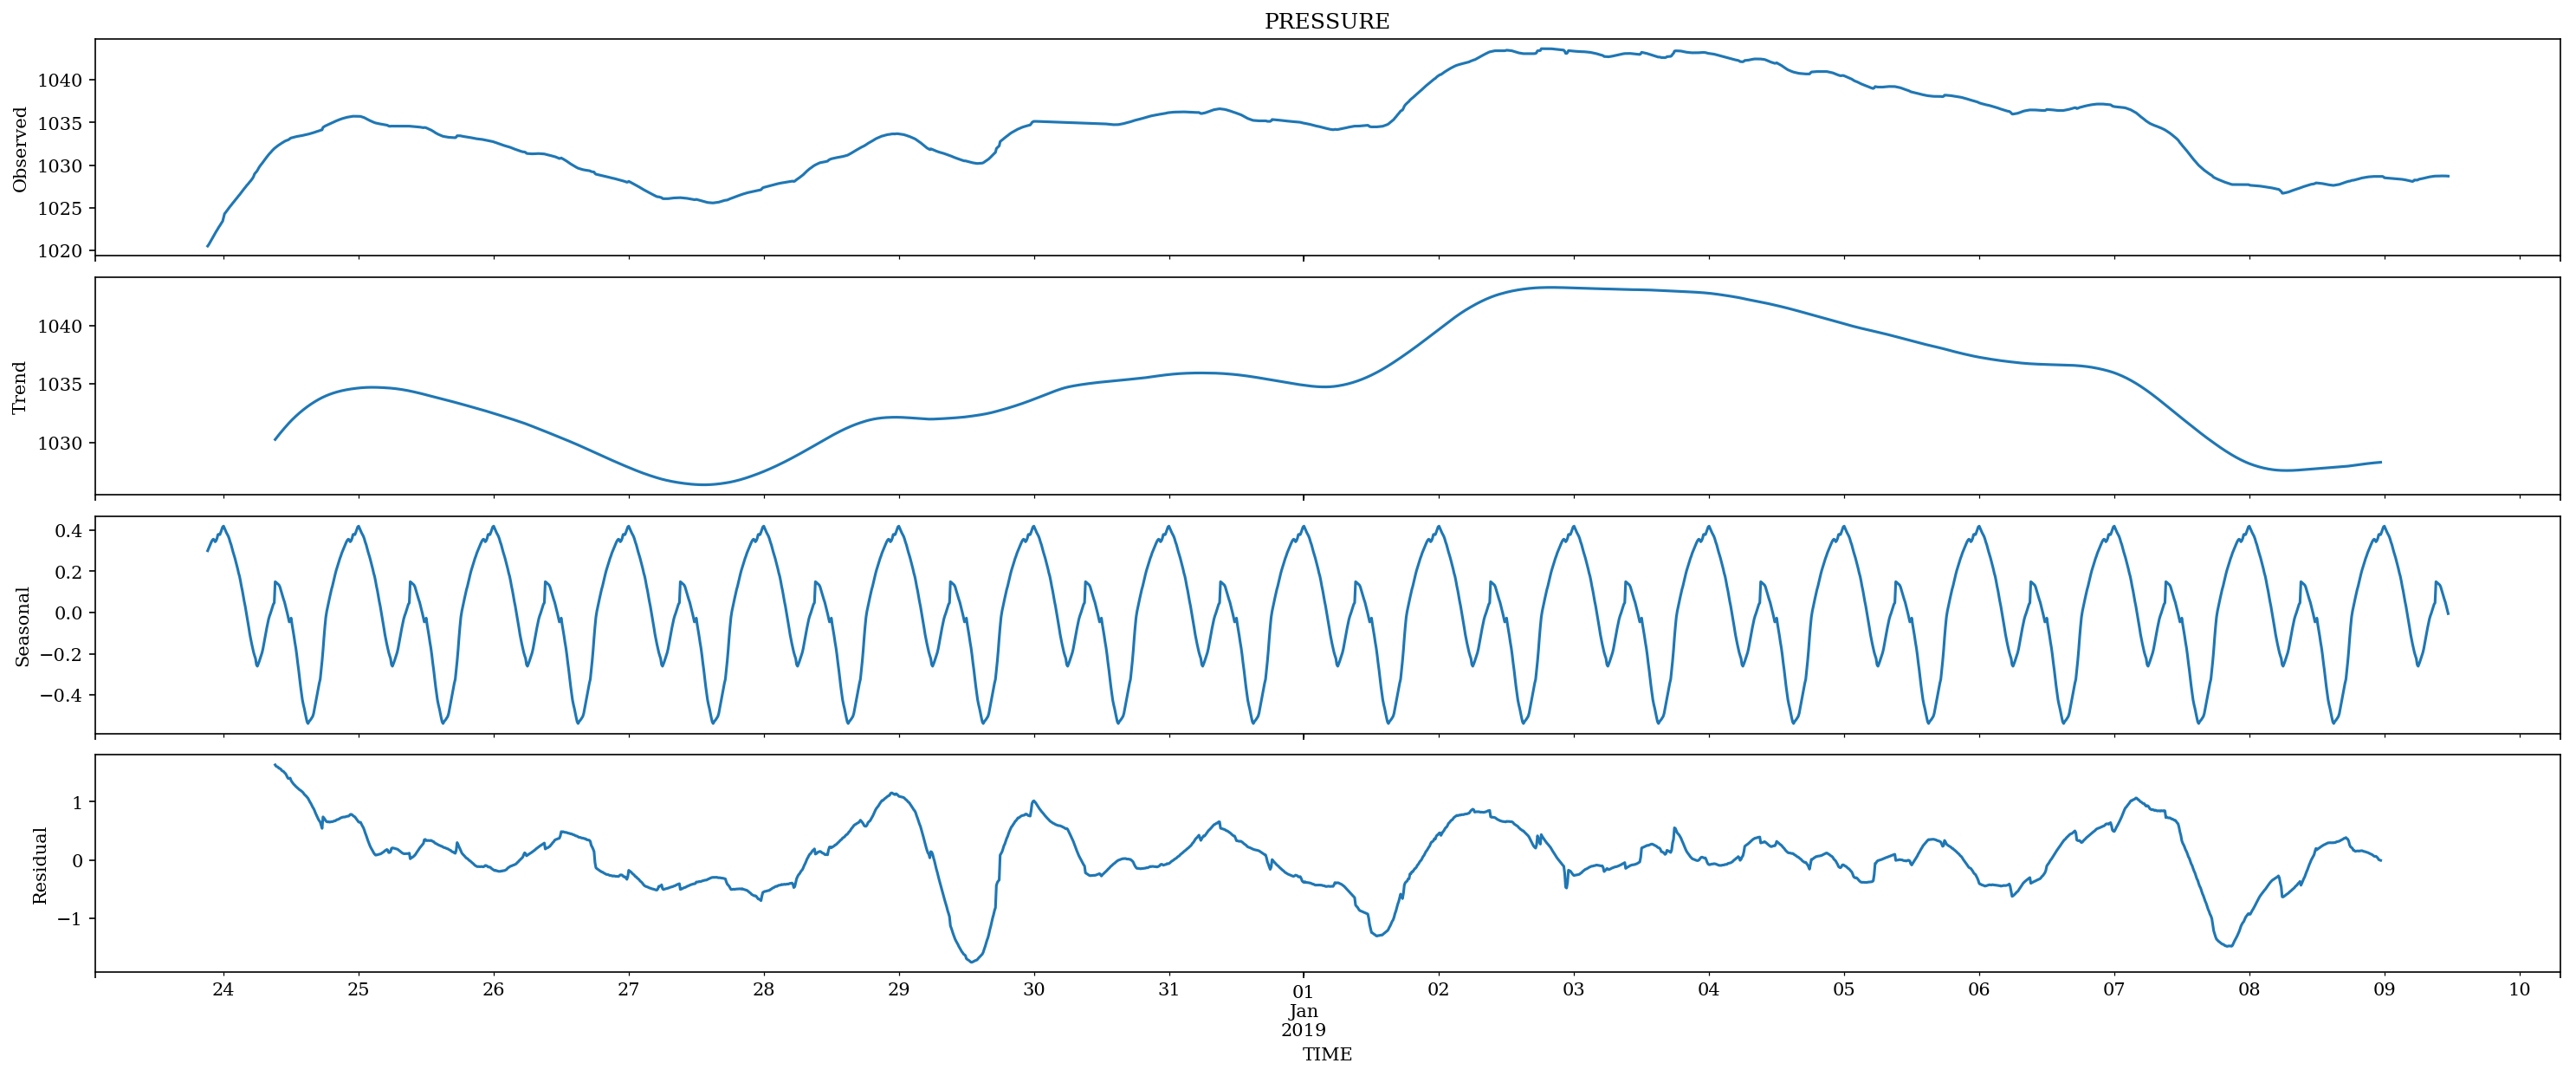

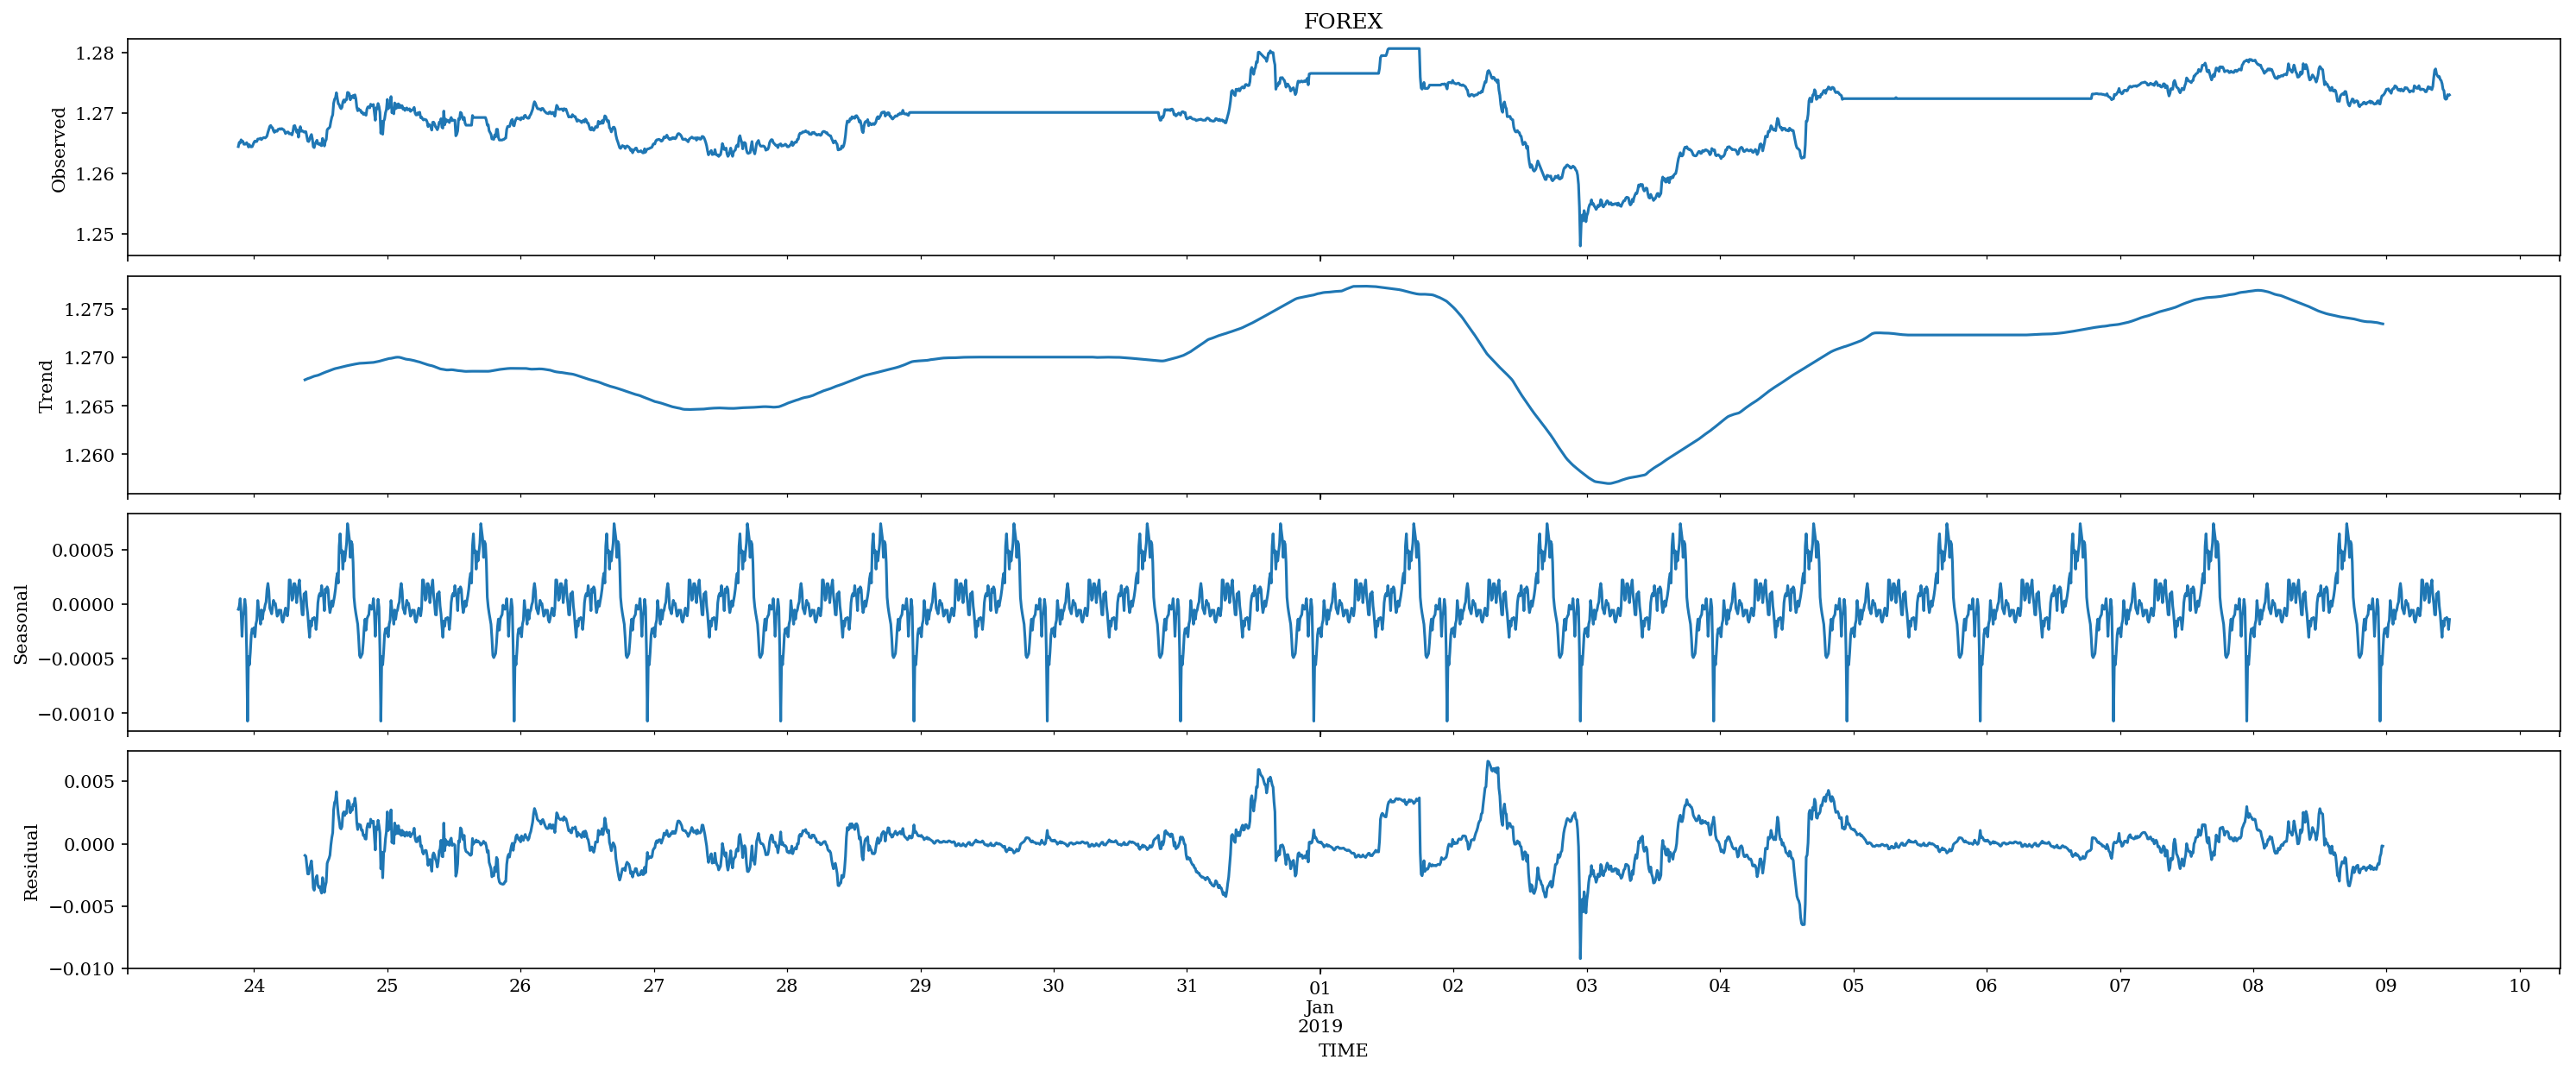

In [9]:
import statsmodels.api as sm

trend_series = []
for i, name in enumerate(cdata.columns.values):
    decomposed = sm.tsa.seasonal_decompose(cdata[name],freq=48*3)
    trend_series.append(decomposed.trend)
    figure = decomposed.plot()
    figure.axes[0].set_title(name)
    figure.set_size_inches(20,8)

trends = pd.concat(trend_series, axis=1)
plt.show()

## Comparing Normalised Data

Both the source data and the trends derived from the seasonal decomposition were normalised in order to compare between multiple datasets.

In [20]:
# create new dataframes to store normalised data
ndata = cdata.copy(deep=True)
ntrends = trends.copy(deep=True)

stats = {}

for name in ndata.columns.values:
    mean = np.mean(ndata[name])
    stdv = np.std(ndata[name])
    stats[name] = {"mean":mean,"stdv":stdv}
    ndata[name] = (ndata[name] - mean) / stdv

for name in trends.columns.values:
    trends[name] = ( trends[name] - np.mean(trends[name]) ) / np.std(trends[name])

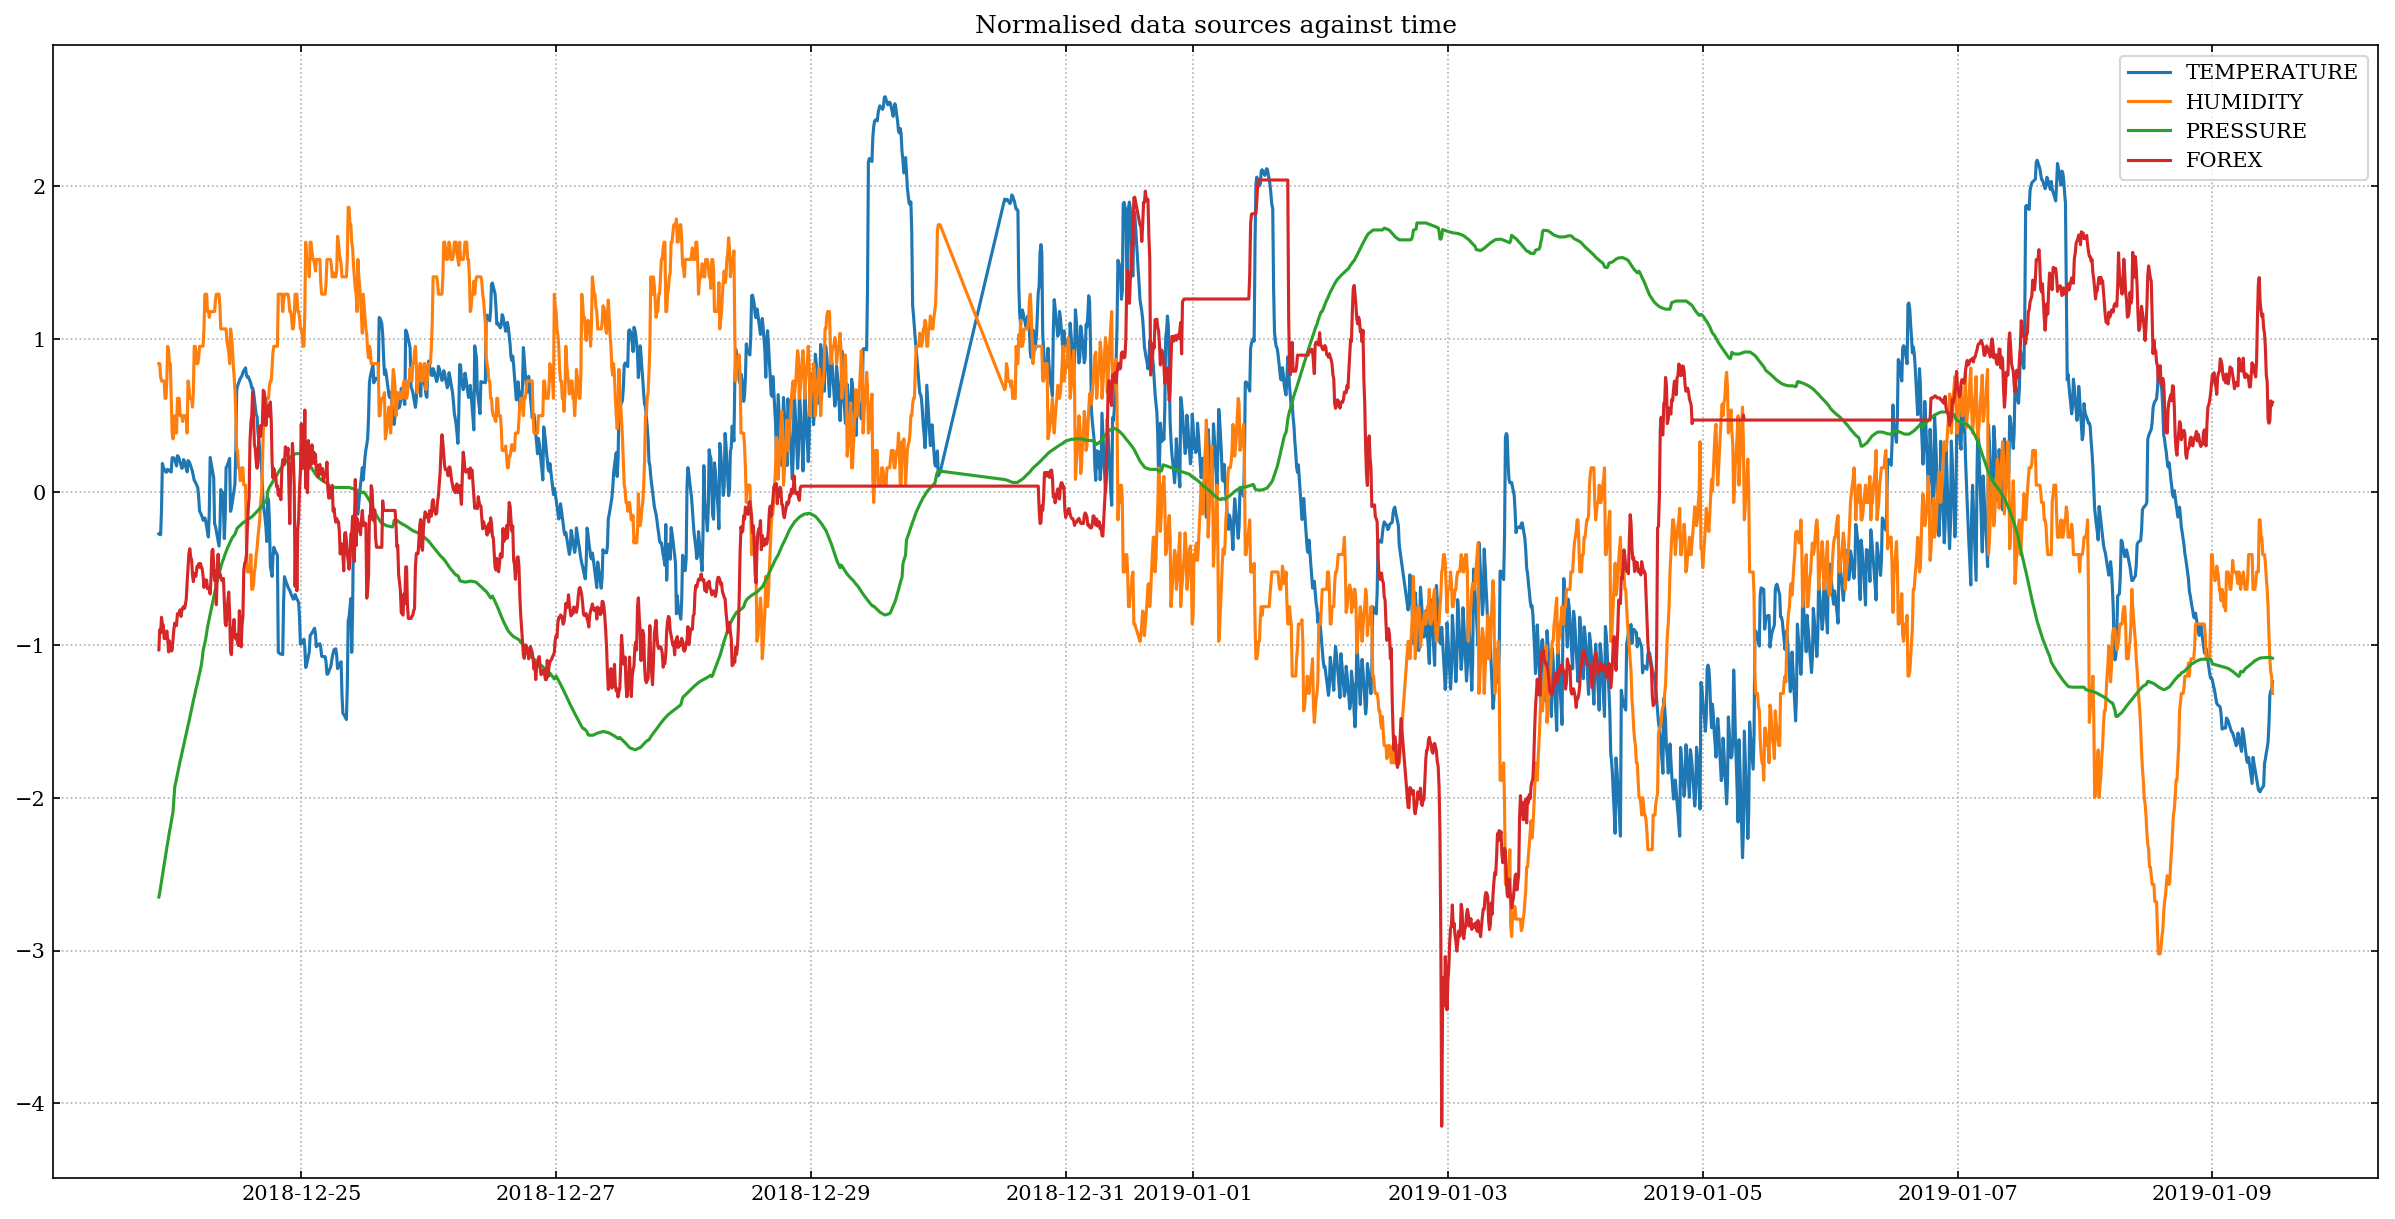

In [14]:
fig, axs = newfigure()

for name in ndata.columns.values: 
    axs.plot(ndata[name])

axs.set_title("Normalised data sources against time")
axs.legend()
plt.show()

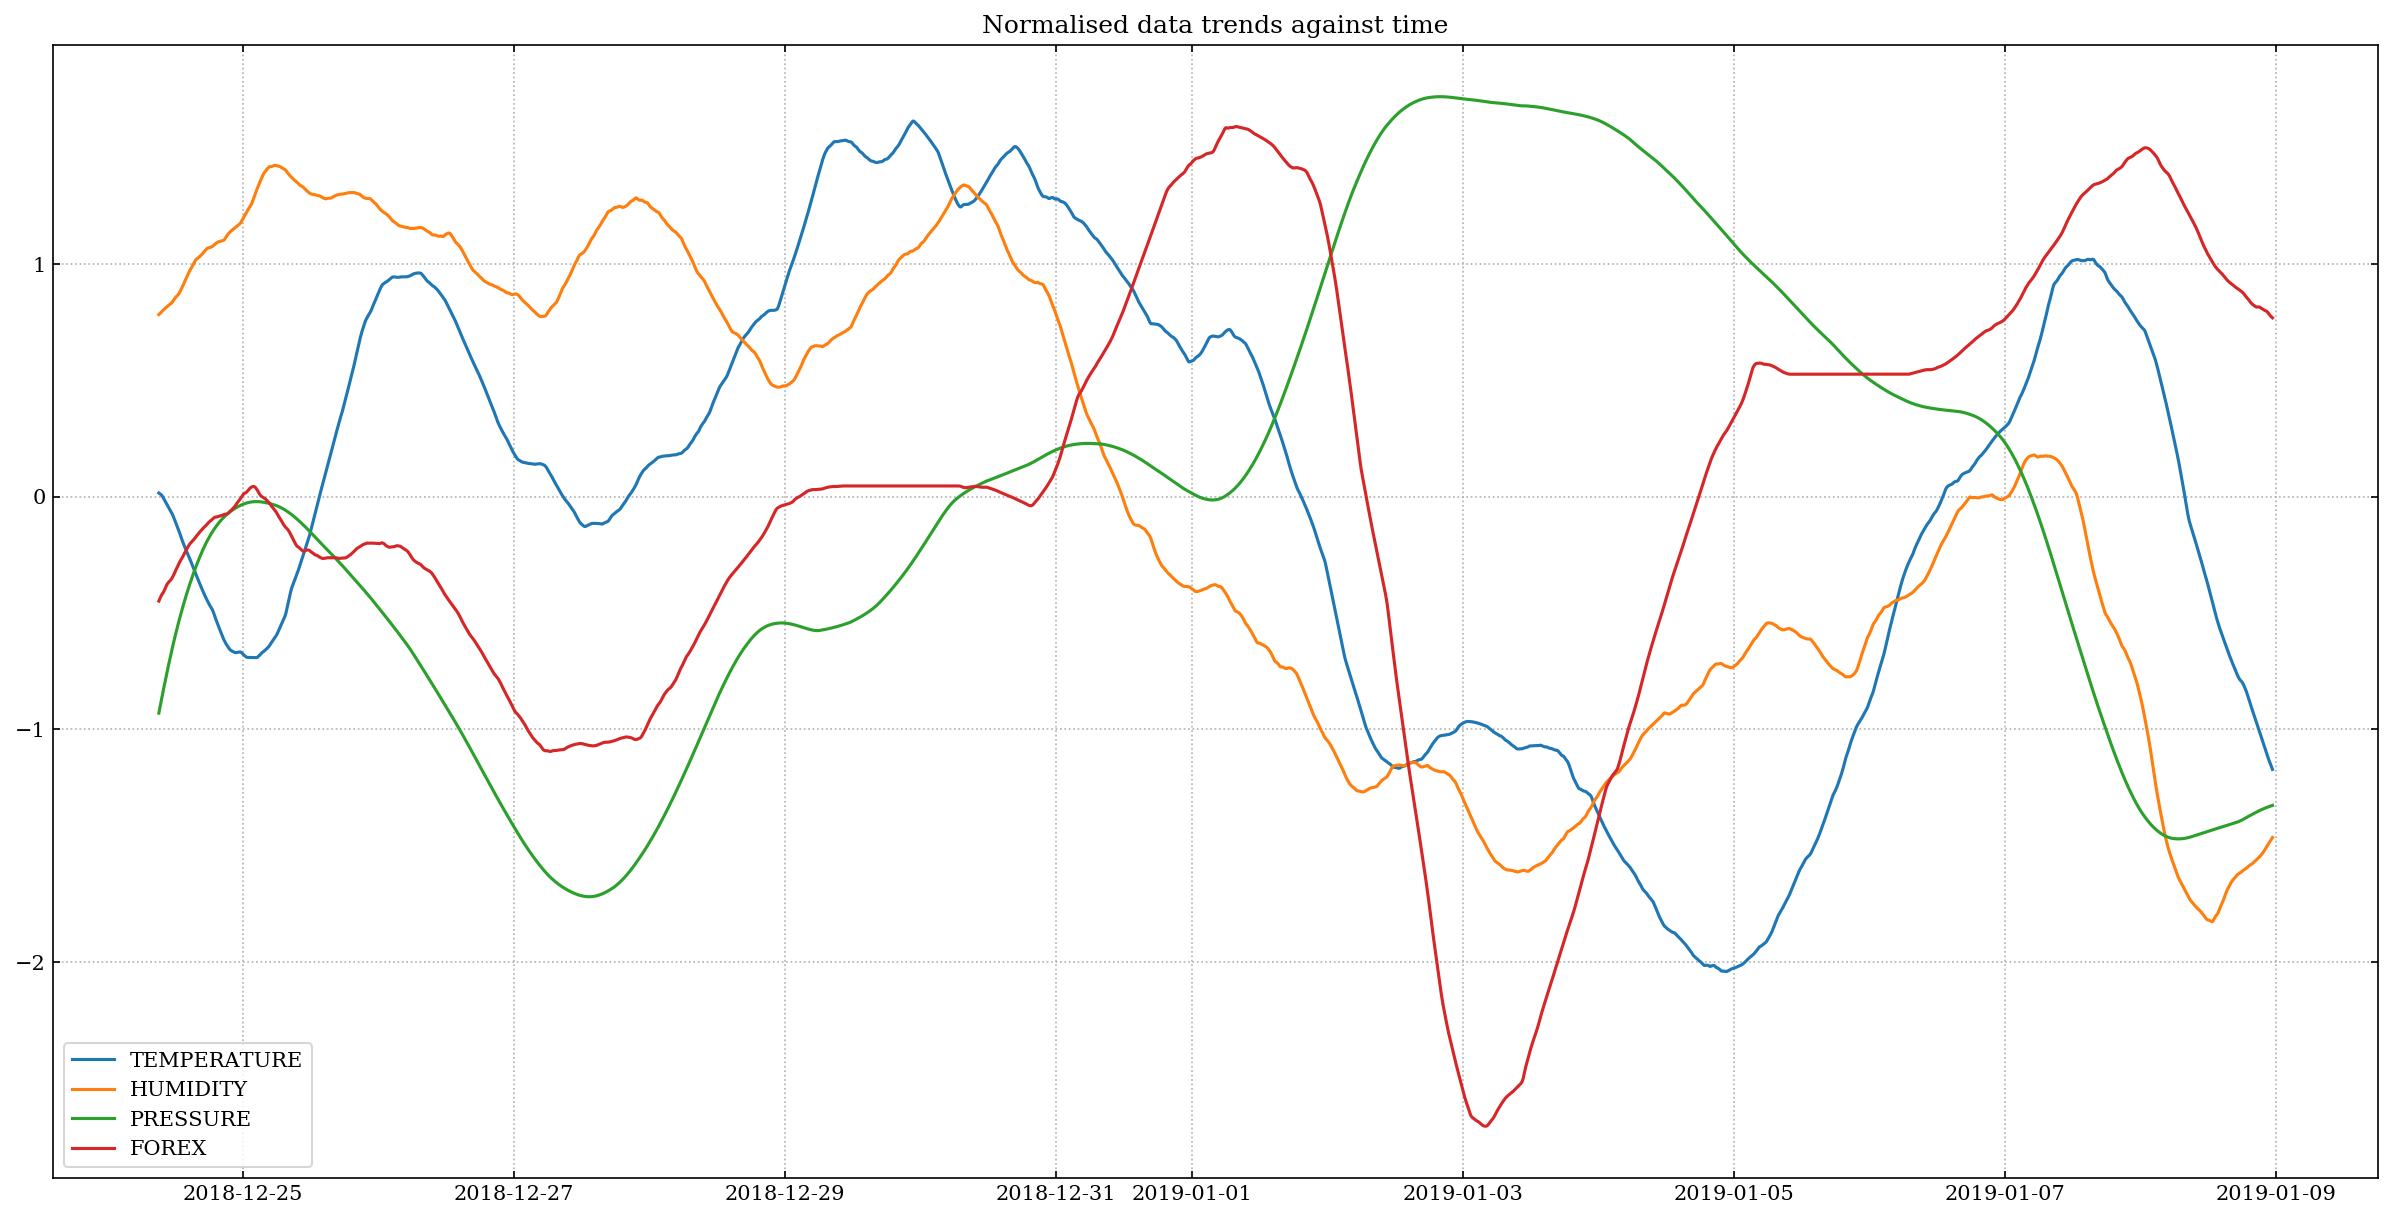

In [15]:
fig, axs = newfigure()

for name in ntrends.columns.values: 
    axs.plot(ntrends[name])

axs.set_title("Normalised data trends against time")
axs.legend()
plt.show()

## Autocorrelation and Partial AC

All source data was autocorrelated against itself.

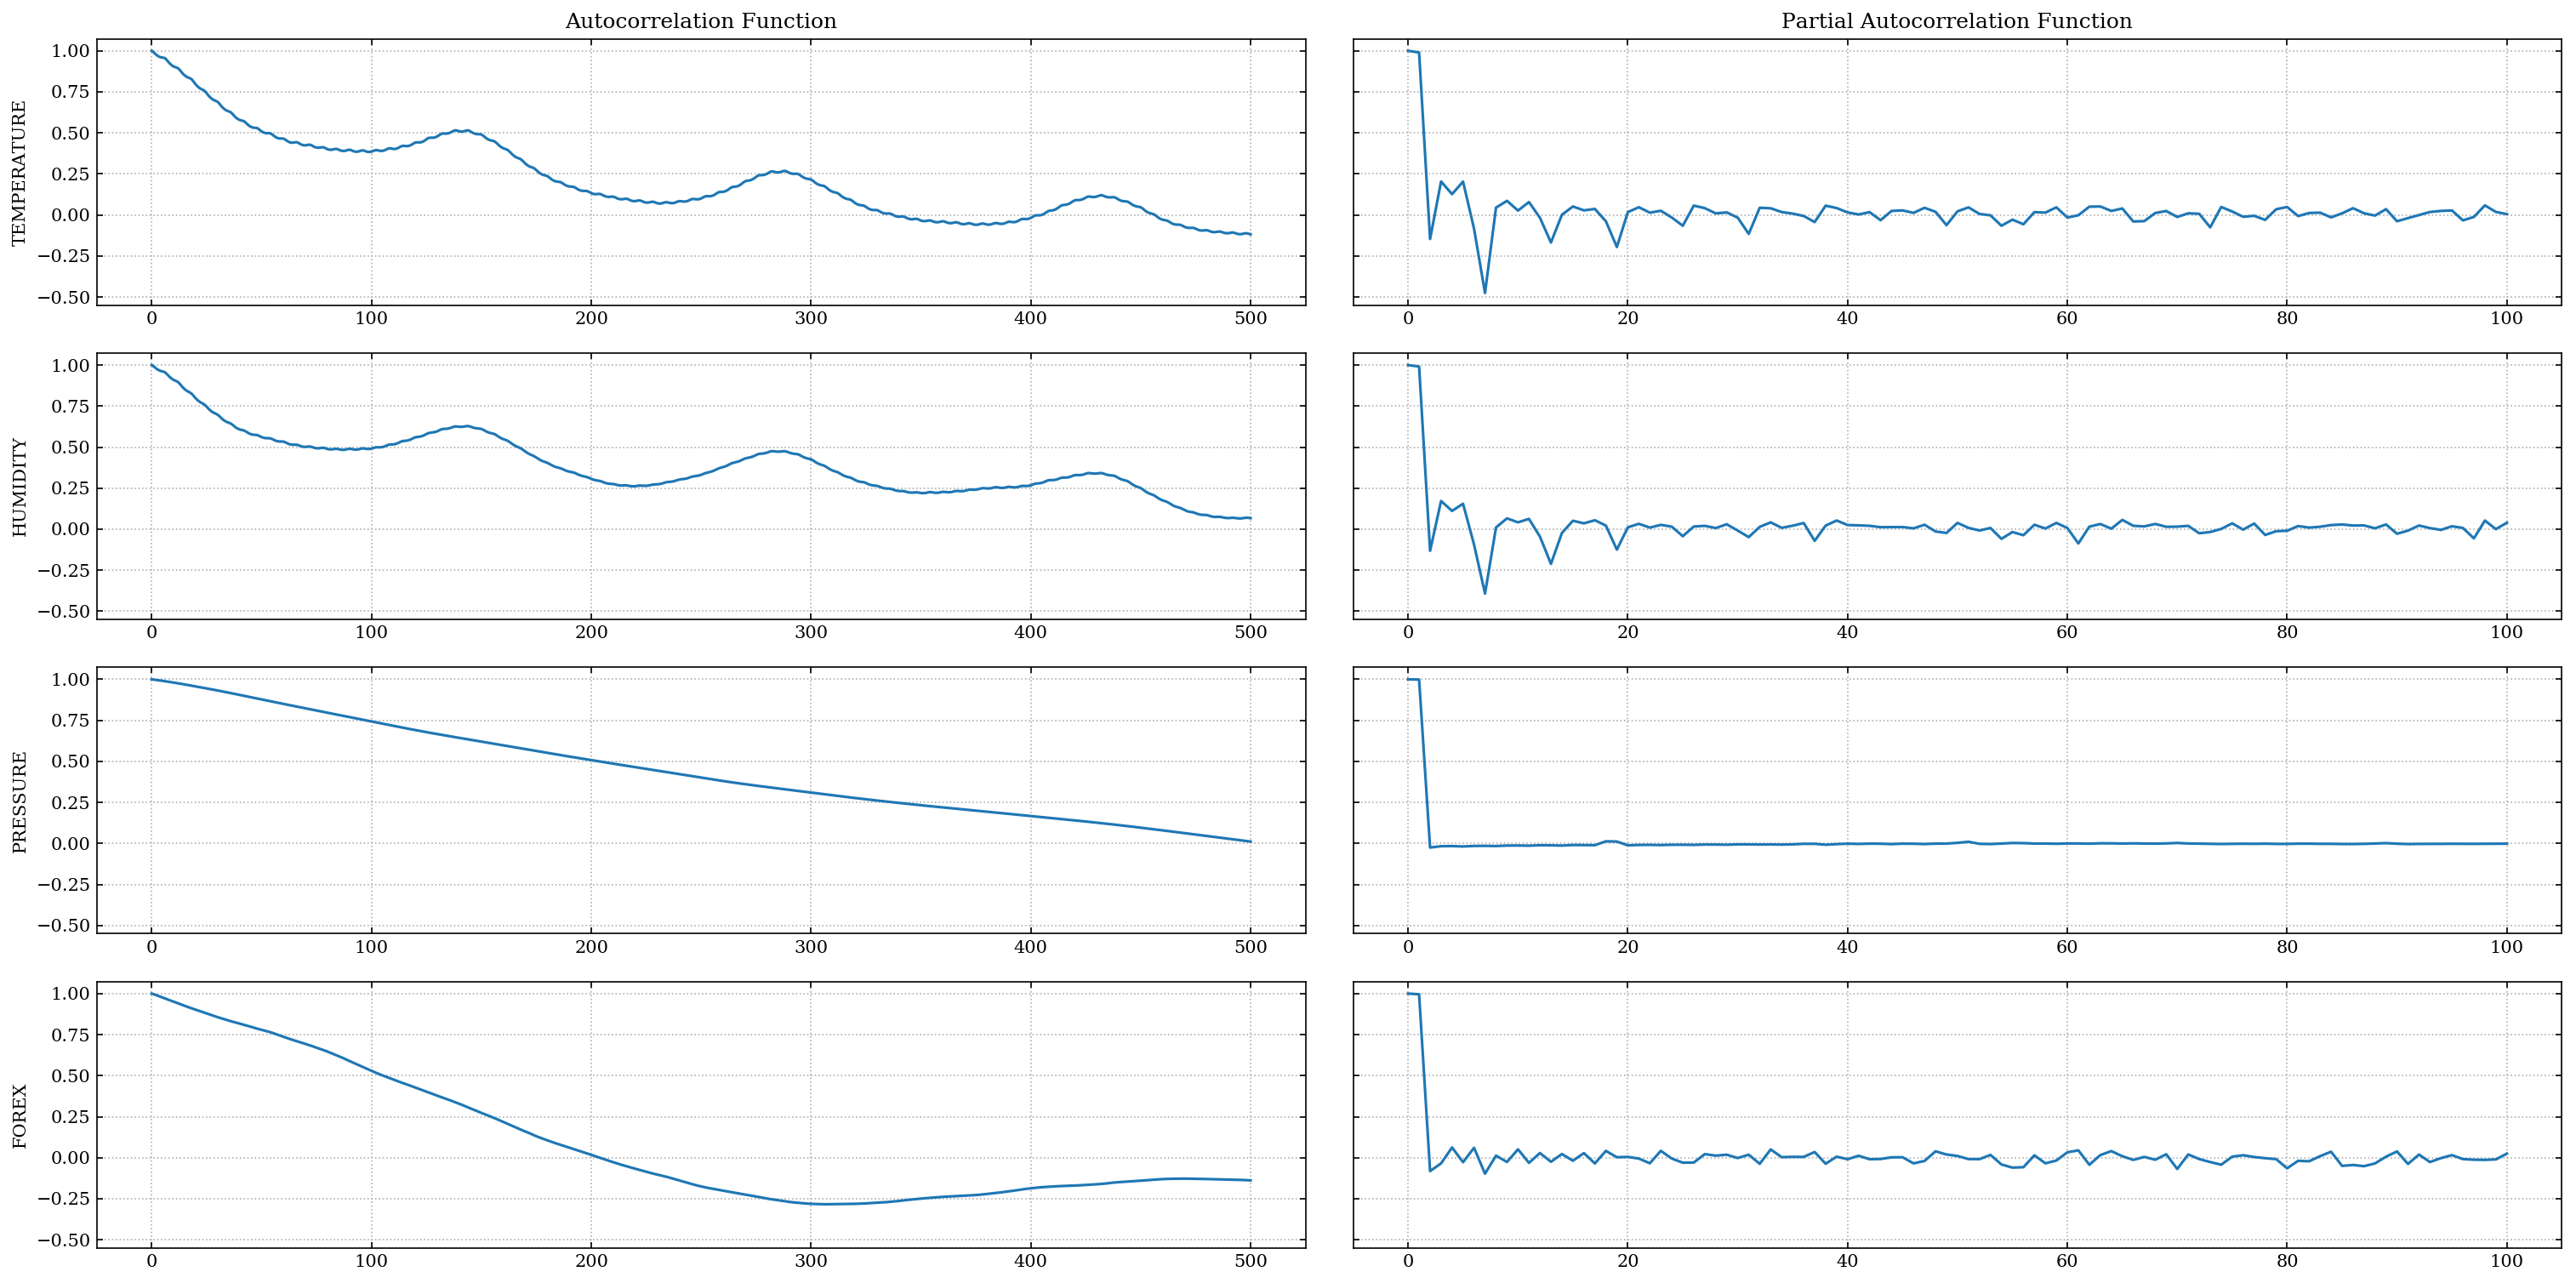

In [16]:
# Autocorrelation and partial autocorrelation plotting
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

config = [
    {"data":weather["DS_TEMP"],"label":"Temperature"},
    {"data":weather["DS_HUM"],"label":"Humidity"},
    {"data":weather["DS_PRESSURE"],"label":"Pressure"},
    {"data":stocks['AV_GBP_USD'],"label":"Forex"}
]

# config = ["DS_TEMP", "DS_HUM", "DS_PRESSURE"]

acf_lags = 500
pacf_lags = 100
fig, axs = newfigure(len(config),2, figsize=(20,10), sharey=True)
fig.tight_layout()

for i, name in enumerate(cdata.columns.values):
    acf_results = statsmodels.tsa.stattools.acf(cdata[name], nlags=acf_lags)
    pacf_results = statsmodels.tsa.stattools.pacf(cdata[name], nlags=pacf_lags)
    
    axs[i,0].plot(acf_results)
    axs[i,0].set_ylabel(name)
    axs[i,1].plot(pacf_results)

axs[0,0].set_title("Autocorrelation Function")
axs[0,1].set_title("Partial Autocorrelation Function")
plt.show()

## Cross Correlation

A complete cross correlation analysis, particularly focusing in on correlation of the Forex price against various weather metrics show that there is no signinifcant correlation whatsoever, even with up to 48 hours of lag.

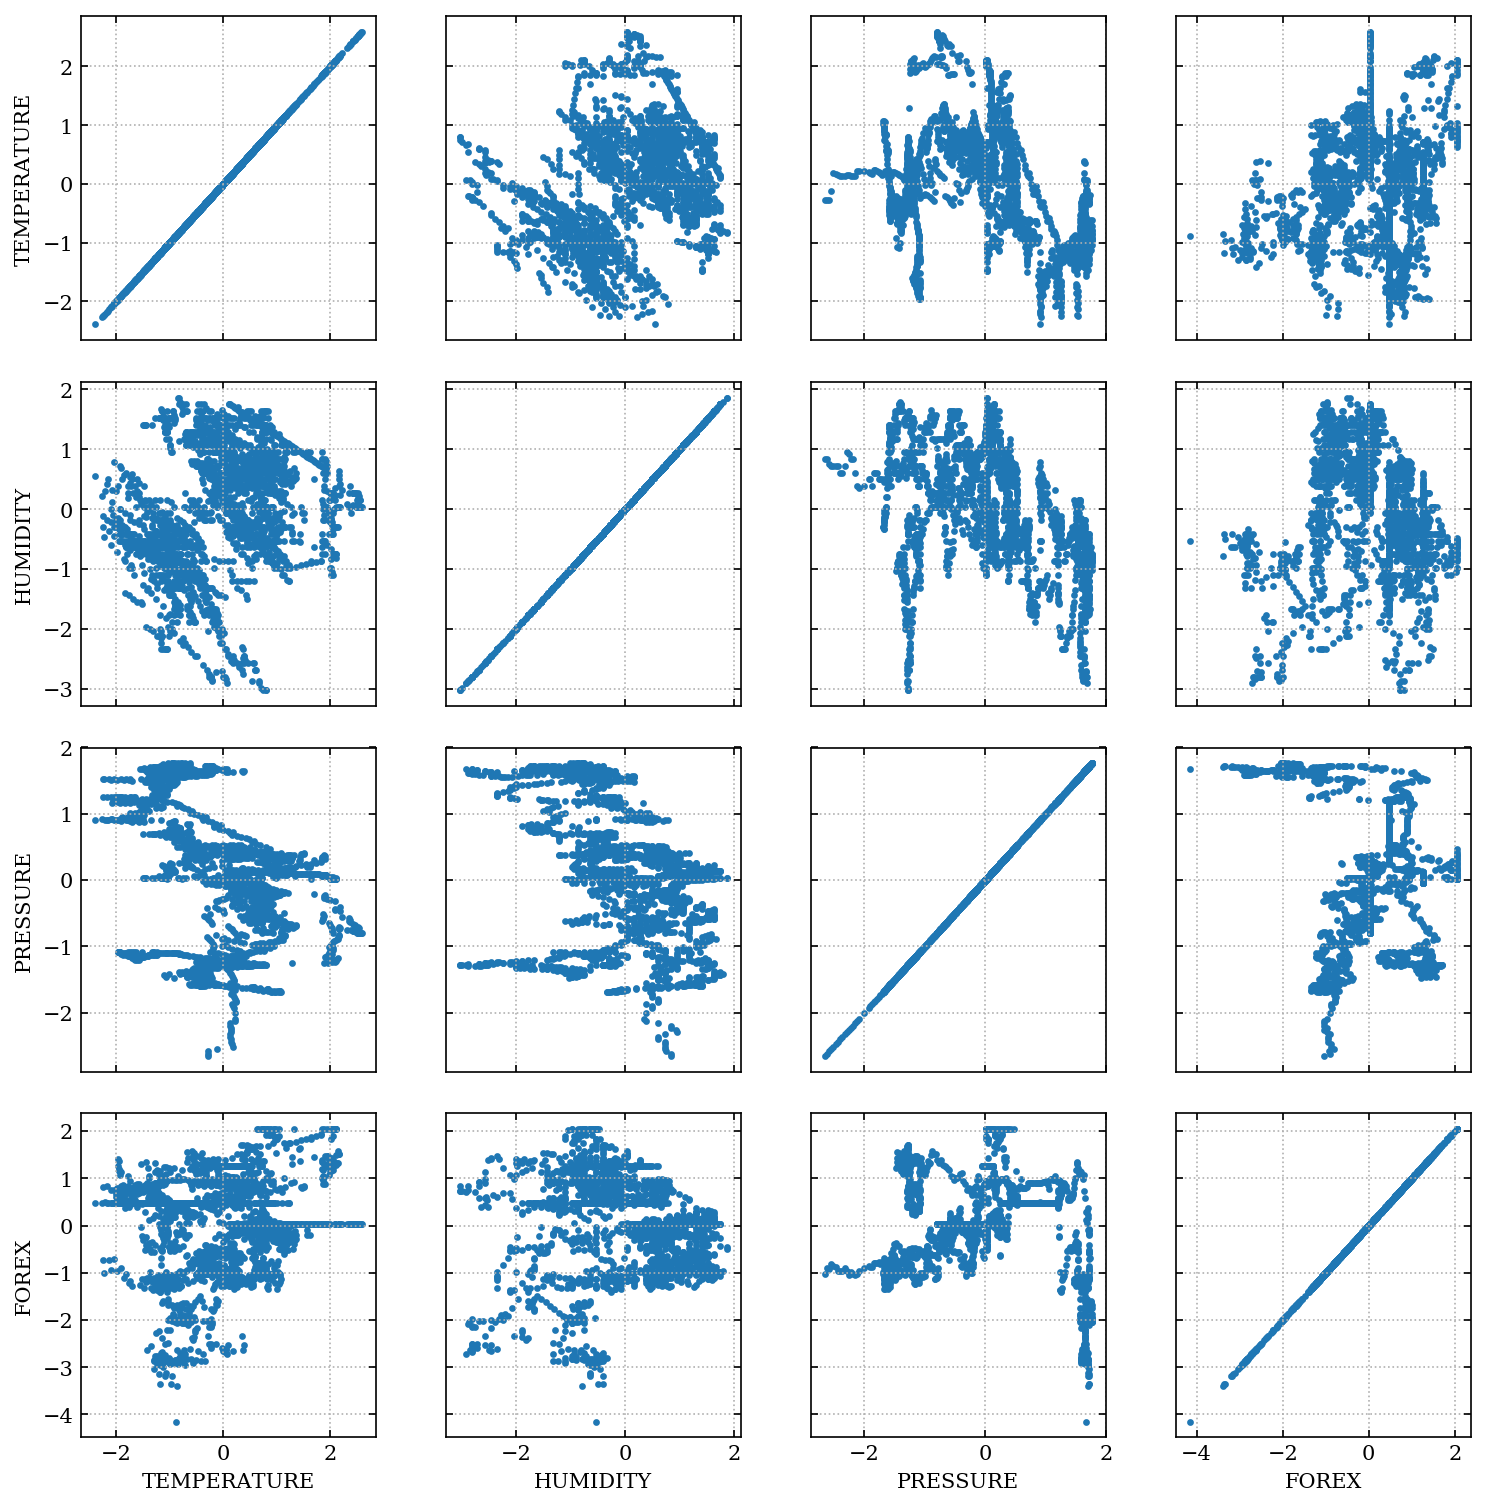

In [17]:
# scatter matrix

def plot_scatter_matrix(data):
    dim = len(data.columns.values)
    fig, axs = newfigure(dim, dim, sharex='col', sharey='row', figsize=(10,10))
    fig.tight_layout()
    for row, iname in enumerate(data.columns.values):
        for col, jname in enumerate(data.columns.values):
            axs[row,col].scatter(data[jname], data[iname], s=5)
#             axs[row,col].set_aspect(1.0, adjustable='box', share=True)
            if col == 0:
                axs[row,col].set_ylabel(iname)
            if row == len(data.columns.values)-1:
                axs[row,col].set_xlabel(jname)
            
    return fig, axs

fig, axs = plot_scatter_matrix(ndata)
plt.show()

#violin plot for distribution of different datasets

       index  TEMPERATURE  HUMIDITY  PRESSURE
INDEX                                        
0          0     0.193535 -0.057944 -0.225749
1          1     0.195061 -0.057143 -0.226099
2          2     0.196431 -0.056249 -0.226469
3          3     0.197641 -0.055335 -0.226704
4          4     0.198842 -0.054262 -0.226974


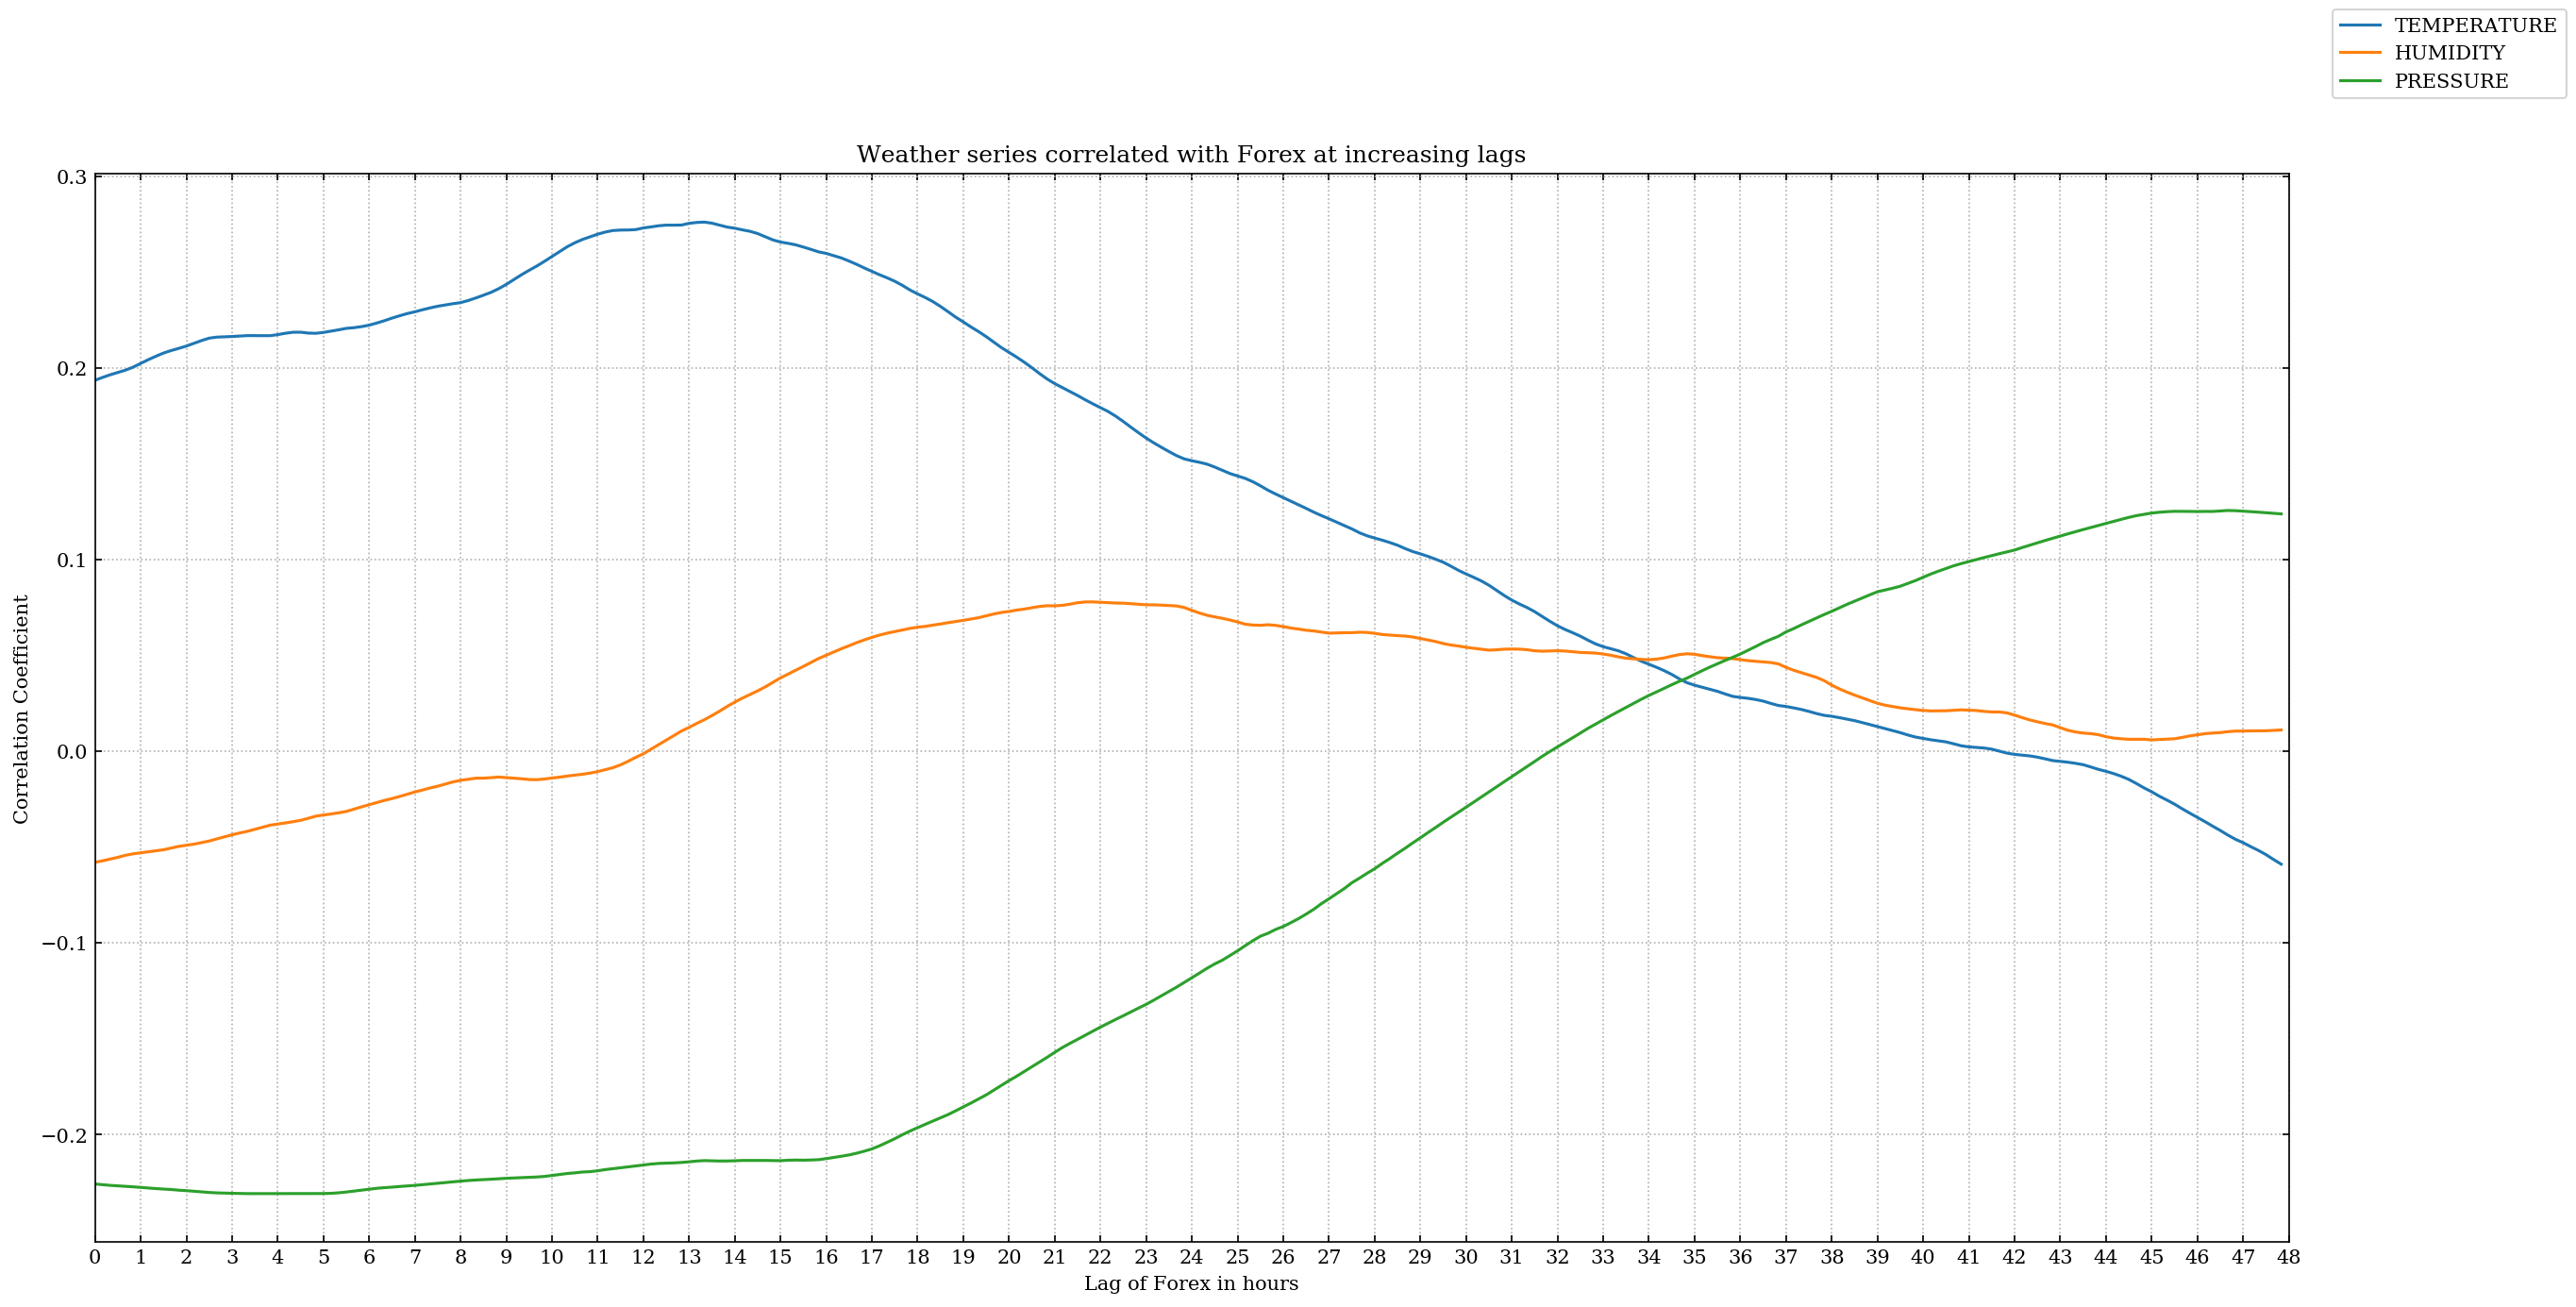

In [44]:
import matplotlib.ticker as ticker
names = ['TEMPERATURE', 'HUMIDITY', 'PRESSURE']
fig, axs = newfigure()

series = []
for name in names:
    prs = []
    for lag in range(48*6):
        result = scipy.stats.pearsonr(cdata[name][:-lag-1], cdata['FOREX'][lag+1:])  
        prs.append(result[0])
    axs.plot(prs, label=name)
    series.append(pd.Series(prs, name=name))

corr_data = pd.concat(series, axis=1).reset_index().rename_axis("INDEX")
print(corr_data.head())

xp = np.linspace(0, 48*6, 48+1, True)
axs.set_xticks(xp)
axs.set_xticklabels([int(i/6) for i in xp])
axs.set_xlabel("Lag of Forex in hours")
axs.set_xlim(0,48*6)

axs.set_ylabel("Correlation Coefficient")

fig.legend()
plt.title("Weather series correlated with Forex at increasing lags")
plt.show()

## Export Data

This final stage will export data to be displayed on the project website.

In [45]:
import json

with open('data_stats.json', 'w') as fp:
    json.dump(stats, fp)
    
cdata.to_csv("data_all.csv")
ntrends.to_csv("data_trends_norm.csv")
corr_data.to_csv("data_correlations.csv")